# Оптимизация расходов для металлургического  комбината ООО «Так закаляем сталь»

### Список вопросов Тимлиду:
1. Колличесво замеров температуры в разных партиях различное от 1 до 16. От сюда вопрос какую температуру нам нужно предсказать: первую, на каждом замере или последнею?
2. Не по всем партиям есть данные. Нужно сравнять колличесво партий, уменьшив количесво, или запониить пропуски?
3. Можно ли исклюдчить данные о подаче сыпучих материалов (время) и данные о проволочных материалах (время) из общей таблицы при обучение модели?


### План выполнения работы:
1. Предобработка данных (пропуски, аномалии)
    - пропуски, аномалии
    - добавить признаки:
        - полную мощность
        - продолжительность нагрева.
2. Объединение данных в одну таблицу по "key"
3. Обучить несколько моделей. 
4. Сравнить результаты и выбрать лучшую.


### Отчёт по работе:

1. **Какие пункты плана были выполнены, а какие — нет (поясните почему)?**
    - *в ходе работы выполнил все запланированные этапы*
2. **Какие трудности возникли и как вы их преодолели?**
    - *самый сложный этам - предобработка данных и формирование общей таблицы. решил с помощью свобных таблиц.*
3. **Какие ключевые шаги в решении задачи выделили?**
    - *Исследование данных, Предобработка, Подготовка данных, Построение моделей, Анализ результатов*
4. **Какая ваша итоговая модель и какое у неё качество?**
    - *CatBoostRegressor, модель показала хорошее качество 6.07.*

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

|Название файла|Описание|
|:-------|:--------|
|`data_arc.csv` |данные об электродах|
|`data_bulk.csv` | данные о подаче сыпучих материалов (объём)|
|`data_bulk_time.csv` | данные о подаче сыпучих материалов (время)|
|`data_gas.csv` | данные о продувке сплава газом|
|`data_temp.csv` | результаты измерения температуры|
|`data_wire.csv` | данные о проволочных материалах (объём)|
|`data_wire_time.csv` | данные о проволочных материалах (время)|

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**Целевой признак:** последняя измеренная температура.

**Метрика:** MAE

**Критерии оценки:**
- MAE > 8.7 — 0 sp
- 7.6 < MAE ≤ 8.7 — 4 sp
- 6.8 < MAE ≤ 7.6 — 4.5 sp
- 6.3 < MAE ≤ 6.8 — 5 sp
- 6.0 < MAE ≤ 6.3 — 5.5 sp
- MAE ≤ 6.0 — 6 sp

## Содержание:
1. [Загрузка и исследование данных.](#load_data)
2. [Предобработка данных и формирование общей таблицы.](#step2)
3. [Обучение модели.](#step3)<br/>
    3.1. [CatBoostRegressor](#step3.1)<br/>
    3.2. [DecisionTreeRegressor](#step3.2)<br/>
    3.3. [RandomForestRegressor](#step3.3)<br/>
    3.4. [LGBMRegressor](#step3.4)<br/>
4. [Анализ результатов](#step4)

## 1. Загрузка и исследование данных. <a class="anchor" id="load_data"></a>

In [3]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import notebook
from tqdm import tqdm
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

# модель
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# метрика
from sklearn.metrics import mean_absolute_error

In [4]:
# чтение файла и печать общей информации
df_arc = pd.read_csv('data_arc.csv')
df_bulk = pd.read_csv('data_bulk.csv')
df_bulk_time = pd.read_csv('data_bulk_time.csv')
df_gas = pd.read_csv('data_gas.csv')
df_temp = pd.read_csv('data_temp.csv')
df_wire = pd.read_csv('data_wire.csv')
df_wire_time = pd.read_csv('data_wire_time.csv')

# данные об электродах
display(df_arc.head())
display(df_arc.info())

display(df_arc.isnull().sum())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

В данных представлены время нагрева и **Активная и Реактивная мощности**. Думаю в дальнейшем потребуется рассчет **Полной мощности**

**Формула для расчета Полной мощности:**
$$
S=\sqrt{P^2+Q^2}
$$

где: 
- $P$ — активная мощность, 
- $Q$ — реактивная мощность 

In [5]:
# данные о подаче сыпучих материалов (объём)
display(df_bulk.head())
display(df_bulk.info())
display(df_bulk.isnull().sum())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [6]:
# данные о подаче сыпучих материалов (время)
display(df_bulk_time.head())
display(df_bulk_time.info())


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

In [7]:
# данные о продувке сплава газом
display(df_gas.head())
display(df_gas.info())
display(df_gas.isnull().sum())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

key      0
Газ 1    0
dtype: int64

In [8]:
# результаты измерения температуры
display(df_temp.head())
display(df_temp.info())
display(df_temp.isnull().sum())

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

key                0
Время замера       0
Температура     2901
dtype: int64

In [9]:
# функция для построения 2 графиков
def boxprint(colum, bins):
    print(colum.describe())
    q1 = colum.quantile(0.25)
    q3 = colum.quantile(0.75)
    iqr = q3 - q1
    colum.hist(bins=bins, range=((q1-1.5*iqr), (q3+3*iqr)))
    plt.show()
    sns.boxplot(x=colum, color='red')

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64


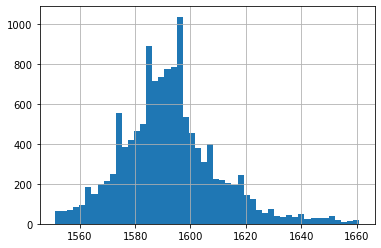

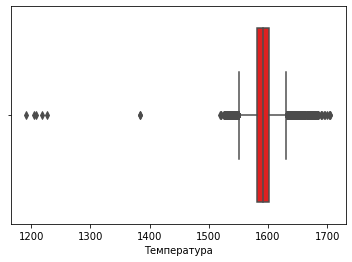

In [10]:
# посмотрим на распределение температур
boxprint(df_temp['Температура'], 50)

In [11]:
# посмотрим на выбросы
df_temp.query('Температура < 1500')

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


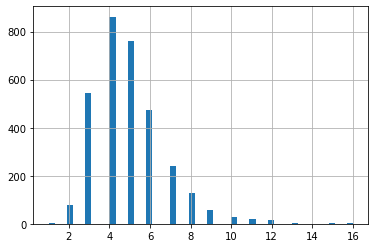

In [12]:
df_temp['key'].value_counts().hist(bins=50)

На графике видно, что подавляющее большенсво замеров находится в промежутке от 1500 до 1700 градусов, поэтому для лучшего качества модели удалим выбросы - замеры менее 1500 их всего 7 штук.

Также, колличесво замеров температуры различое на каждой партии различное, разброс от 1 до 16 при этом подавляющее большинсво находится в диапазоне от 2 до 10
.  

In [13]:
# данные о проволочных материалах (объём)
display(df_wire.head())
display(df_wire.info())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

In [14]:
# данные о проволочных материалах (время)
display(df_wire_time.head())
display(df_wire_time.info())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

В данных из таблиц `df_wire` и `df_wire_time`  присутвует множетво пропуском, вероятно это особенность процесса так как в процессе производсва используются не все примеси в каждом этапе, поэтому пропуски можно заменить на 0.

In [15]:
print('Данные об электродах', df_arc['key'].value_counts().shape[0])
print('Данные о подаче сыпучих материалов (объём)', df_bulk['key'].value_counts().shape[0])
print('Данные о подаче сыпучих материалов (время)', df_bulk_time['key'].value_counts().shape[0])
print('Данные о продувке сплава газом', df_gas['key'].value_counts().shape[0])
print('Результаты измерения температуры', df_temp['key'].value_counts().shape[0])
print('Данные о проволочных материалах (объём)', df_wire['key'].value_counts().shape[0])
print('Данные о проволочных материалах (время)', df_wire_time['key'].value_counts().shape[0])

Данные об электродах 3214
Данные о подаче сыпучих материалов (объём) 3129
Данные о подаче сыпучих материалов (время) 3129
Данные о продувке сплава газом 3239
Результаты измерения температуры 3216
Данные о проволочных материалах (объём) 3081
Данные о проволочных материалах (время) 3081


Не по всем партиям есть все данные. 

## 2. Предобработка данных и формирование общей таблицы. <a class="anchor" id="step2"></a>

#### Расчёт полной мощности и продолжительности нагрева дугой

In [16]:
# рассчитаем полную мощность
df_arc['Полная мощность'] = np.sqrt((np.array(df_arc['Активная мощность']) ** 2) + 
                                    (np.array(df_arc['Реактивная мощность']) ** 2)
                                   )

# рассчитаем продолжительность нагрева
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'],
                                                format='%Y-%m-%dT%H:%M:%S')
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'],
                                               format='%Y-%m-%dT%H:%M:%S')
df_arc['Время нагрева, секунд'] = ((df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой'])
                                   .dt.total_seconds()
                                   .astype(int)
                                  )
# уберем ненужные столбцы
data_arc_final=df_arc[['key', 'Время нагрева, секунд', 'Полная мощность']]
data_arc_final.head(3)

,key,"Время нагрева, секунд",Полная мощность
0,1,228,1.193639
1,1,185,0.959010
2,1,172,0.896038


#### Предобработка таблицы с Температурой.

In [17]:
# удалим выбросы
df_temp = df_temp.query('Температура >= 1450')

Партии, где только 1 замер температуры убираем так как нам нужен первый и последний. Для создадим новую таблицу с столбцами key и Колличество замером и затем присодиним к основной таблице и сделаем срез, чтобы убрать не нужные строки.

In [18]:
df_temp.groupby('key').count().head(3)

,Время замера,Температура
key,,
1,5,5
2,6,6
3,5,5


In [19]:
# создадим новый столбец
df_temp_count = df_temp.groupby('key').count()
df_temp_count['Количество_замеров'] = df_temp_count[['Температура']]
df_count_temp = df_temp_count[['Количество_замеров']]
display(df_count_temp.head())

# объединим таблицы
df_count_temp = df_count_temp.reset_index(drop=False)
df_temp = df_temp.merge(df_count_temp, on='key')
display(df_temp.tail(3))

,Количество_замеров
key,
1,5
2,6
3,5
4,3
5,2


,key,Время замера,Температура,Количество_замеров
12996,3239,2019-09-01 01:31:47,1598.0,1
12997,3240,2019-09-01 02:39:01,1617.0,1
12998,3241,2019-09-01 04:03:30,1586.0,1


In [20]:
# уберем партии с одним замером
df_temp = df_temp.query('Количество_замеров > 1')
display(df_temp.tail(3))

,key,Время замера,Температура,Количество_замеров
12258,2499,2019-08-06 02:40:25,1569.0,3
12259,2499,2019-08-06 02:54:24,1604.0,3
12260,2499,2019-08-06 03:00:28,1603.0,3


#### Формирование таблицы с первым и последним замером температуры

In [21]:
# создадим сводную таблицу с первым замером
data_temp_first = df_temp.pivot_table(index = ["key"],
                                      values = "Время замера", 
                                      aggfunc = "first")

data_temp_first = (data_temp_first
                   .merge(df_temp, on='Время замера')
                   .set_index('key')
                   .rename(columns={"Температура": "Первый_замер"})
                   .drop(['Время замера','Количество_замеров'] , axis=1)
                 )

# создадим сводную таблицу с последним замером
data_temp_last = df_temp.pivot_table(index = ["key"],
                                     values = "Время замера",
                                     aggfunc = "last")

data_temp_last = (data_temp_last.merge(df_temp, on='Время замера')
                  .set_index('key')
                  .rename(columns={"Температура": "Последний_замер"})
                  .drop(['Время замера','Количество_замеров'] , axis=1)
                 )

# объединим 2 таблицы
data_temp_final = data_temp_first.merge(data_temp_last, on='key')
display(data_temp_final)

,Первый_замер,Последний_замер
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


Добавим к полученной таблицы данные по примесям и затраченной мощности.

In [22]:
#
final_data=data_temp_final.merge(data_arc_final, on='key')

final_data = (final_data
              .pivot_table(index = ['key', 'Первый_замер', 'Последний_замер'],
                                    values = ['Время нагрева, секунд', 'Полная мощность'],
                                    aggfunc = 'sum')
              .reset_index(drop=False)
              .set_index('key')
             )
final_data['Первый_замер'] = final_data['Первый_замер'].astype(int)
final_data['Последний_замер'] = final_data['Последний_замер'].astype(int)
display(final_data)

,Первый_замер,Последний_замер,"Время нагрева, секунд",Полная мощность
key,,,,
1,1571,1613,1098,5.826395
2,1581,1602,811,3.649216
3,1596,1599,655,2.989534
4,1601,1625,741,3.814962
5,1576,1602,869,4.035758
...,...,...,...,...
2495,1570,1591,723,3.986869
2496,1554,1591,940,5.057033
2497,1571,1589,569,2.885017


#### Предобработка таблицы с данными по газу.

In [23]:
#
final_data=(final_data
            .merge(df_gas, on='key')
            .set_index('key')
           )
display(final_data.head(1))

,Первый_замер,Последний_замер,"Время нагрева, секунд",Полная мощность,Газ 1
key,,,,,
1,1571,1613,1098,5.826395,29.749986


In [24]:
# запоним пропуски и объединим таблицы
df_wire=df_wire.fillna(0)
df_wire = df_wire.set_index('key')
final_data=final_data.merge(df_wire, on='key')
display(final_data.head(1))

,Первый_замер,Последний_замер,"Время нагрева, секунд",Полная мощность,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,
1,1571,1613,1098,5.826395,29.749986,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### данные о подаче сыпучих материалов 

In [25]:
# запоним пропуски и объединим таблицы
df_bulk = df_bulk.fillna(0)
df_bulk = df_bulk.set_index('key')
final_data=final_data.merge(df_bulk, on='key')
display(final_data)

,Первый_замер,Последний_замер,"Время нагрева, секунд",Полная мощность,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,1098,5.826395,29.749986,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,1581,1602,811,3.649216,12.555561,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,1596,1599,655,2.989534,28.554793,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,1601,1625,741,3.814962,18.841219,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,1576,1602,869,4.035758,5.413692,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570,1591,723,3.986869,7.125735,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2496,1554,1591,940,5.057033,9.412616,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2497,1571,1589,569,2.885017,6.271699,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0


In [26]:
final_data.columns

Index(['Первый_замер', 'Последний_замер', 'Время нагрева, секунд',
       'Полная мощность', 'Газ 1', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Bulk 1', 'Bulk 2',
       'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

В результате слияния данных получилась таблица из 2329 строк и с 29 признаками.

## 3. Обучение модели. <a class="anchor" id="step3"></a>

In [27]:
# разбиение на подвыборки для кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=12345)

# словарь для результатов тесторвания
test_score = {}

In [28]:
# разделение на обучающие признаки и целевой
df_train, df_valid = train_test_split(final_data, test_size=0.20, random_state=12345)

features_train = df_train.drop(['Последний_замер'], axis=1).values
target_train = df_train['Последний_замер'].values

features_valid = df_valid.drop(['Последний_замер'], axis=1).values
target_valid = df_valid['Последний_замер'].values

### 3.1 CatBoostRegressor.<a class="anchor" id="step3.1"></a>

In [29]:
%%time
parameters = {'max_depth': np.arange(5, 7),
              'iterations': np.arange(400, 500, 100),
              'learning_rate': np.arange(0.02, 0.11, 0.03)
             }

gs = GridSearchCV(CatBoostRegressor(random_state=12345), 
                  parameters,
                  verbose = False,
                  cv=kf,
                  scoring='neg_mean_absolute_error')

# обучение
gs.fit(features_train, target_train)


0:	learn: 11.1652341	total: 175ms	remaining: 1m 9s
1:	learn: 11.1066290	total: 179ms	remaining: 35.7s
2:	learn: 11.0513033	total: 185ms	remaining: 24.5s
3:	learn: 10.9892172	total: 191ms	remaining: 18.9s
4:	learn: 10.9340092	total: 197ms	remaining: 15.5s
5:	learn: 10.8833777	total: 203ms	remaining: 13.4s
6:	learn: 10.8282927	total: 212ms	remaining: 11.9s
7:	learn: 10.7770652	total: 223ms	remaining: 10.9s
8:	learn: 10.7287755	total: 229ms	remaining: 9.97s
9:	learn: 10.6793961	total: 236ms	remaining: 9.22s
10:	learn: 10.6280760	total: 248ms	remaining: 8.76s
11:	learn: 10.5807814	total: 255ms	remaining: 8.24s
12:	learn: 10.5352534	total: 261ms	remaining: 7.78s
13:	learn: 10.4878357	total: 266ms	remaining: 7.34s
14:	learn: 10.4389926	total: 272ms	remaining: 6.99s
15:	learn: 10.3958632	total: 281ms	remaining: 6.75s
16:	learn: 10.3542912	total: 289ms	remaining: 6.52s
17:	learn: 10.3165415	total: 295ms	remaining: 6.25s
18:	learn: 10.2799081	total: 300ms	remaining: 6.02s
19:	learn: 10.2423457	

180:	learn: 7.9003282	total: 1.34s	remaining: 1.62s
181:	learn: 7.8962409	total: 1.35s	remaining: 1.61s
182:	learn: 7.8889929	total: 1.35s	remaining: 1.6s
183:	learn: 7.8842208	total: 1.36s	remaining: 1.59s
184:	learn: 7.8791605	total: 1.36s	remaining: 1.58s
185:	learn: 7.8757258	total: 1.37s	remaining: 1.58s
186:	learn: 7.8682641	total: 1.38s	remaining: 1.57s
187:	learn: 7.8603670	total: 1.38s	remaining: 1.56s
188:	learn: 7.8553737	total: 1.39s	remaining: 1.55s
189:	learn: 7.8477383	total: 1.39s	remaining: 1.54s
190:	learn: 7.8438563	total: 1.4s	remaining: 1.53s
191:	learn: 7.8384816	total: 1.4s	remaining: 1.52s
192:	learn: 7.8333826	total: 1.41s	remaining: 1.51s
193:	learn: 7.8295439	total: 1.41s	remaining: 1.5s
194:	learn: 7.8269722	total: 1.42s	remaining: 1.49s
195:	learn: 7.8212182	total: 1.42s	remaining: 1.48s
196:	learn: 7.8151887	total: 1.43s	remaining: 1.47s
197:	learn: 7.8107272	total: 1.43s	remaining: 1.46s
198:	learn: 7.8071605	total: 1.44s	remaining: 1.46s
199:	learn: 7.80

362:	learn: 7.1984780	total: 2.29s	remaining: 233ms
363:	learn: 7.1936369	total: 2.29s	remaining: 227ms
364:	learn: 7.1890590	total: 2.3s	remaining: 221ms
365:	learn: 7.1872207	total: 2.31s	remaining: 214ms
366:	learn: 7.1819873	total: 2.31s	remaining: 208ms
367:	learn: 7.1786578	total: 2.32s	remaining: 202ms
368:	learn: 7.1768998	total: 2.32s	remaining: 195ms
369:	learn: 7.1732865	total: 2.33s	remaining: 189ms
370:	learn: 7.1684253	total: 2.34s	remaining: 183ms
371:	learn: 7.1662783	total: 2.34s	remaining: 176ms
372:	learn: 7.1617082	total: 2.35s	remaining: 170ms
373:	learn: 7.1604331	total: 2.35s	remaining: 163ms
374:	learn: 7.1575825	total: 2.35s	remaining: 157ms
375:	learn: 7.1552233	total: 2.36s	remaining: 151ms
376:	learn: 7.1532781	total: 2.36s	remaining: 144ms
377:	learn: 7.1508903	total: 2.37s	remaining: 138ms
378:	learn: 7.1480622	total: 2.37s	remaining: 132ms
379:	learn: 7.1445617	total: 2.38s	remaining: 125ms
380:	learn: 7.1422730	total: 2.38s	remaining: 119ms
381:	learn: 7

124:	learn: 8.2448256	total: 658ms	remaining: 1.45s
125:	learn: 8.2370410	total: 665ms	remaining: 1.45s
126:	learn: 8.2304884	total: 670ms	remaining: 1.44s
127:	learn: 8.2235045	total: 676ms	remaining: 1.44s
128:	learn: 8.2146812	total: 681ms	remaining: 1.43s
129:	learn: 8.2084341	total: 686ms	remaining: 1.42s
130:	learn: 8.1991431	total: 692ms	remaining: 1.42s
131:	learn: 8.1941170	total: 699ms	remaining: 1.42s
132:	learn: 8.1839227	total: 704ms	remaining: 1.41s
133:	learn: 8.1770850	total: 709ms	remaining: 1.41s
134:	learn: 8.1712888	total: 713ms	remaining: 1.4s
135:	learn: 8.1646305	total: 718ms	remaining: 1.39s
136:	learn: 8.1569042	total: 722ms	remaining: 1.39s
137:	learn: 8.1508837	total: 727ms	remaining: 1.38s
138:	learn: 8.1418866	total: 732ms	remaining: 1.37s
139:	learn: 8.1359041	total: 736ms	remaining: 1.37s
140:	learn: 8.1295095	total: 741ms	remaining: 1.36s
141:	learn: 8.1210376	total: 745ms	remaining: 1.35s
142:	learn: 8.1140542	total: 749ms	remaining: 1.35s
143:	learn: 8

287:	learn: 7.4265008	total: 1.48s	remaining: 575ms
288:	learn: 7.4222535	total: 1.48s	remaining: 570ms
289:	learn: 7.4192454	total: 1.49s	remaining: 565ms
290:	learn: 7.4147202	total: 1.5s	remaining: 560ms
291:	learn: 7.4131039	total: 1.5s	remaining: 555ms
292:	learn: 7.4126066	total: 1.5s	remaining: 549ms
293:	learn: 7.4090542	total: 1.51s	remaining: 544ms
294:	learn: 7.4052851	total: 1.51s	remaining: 538ms
295:	learn: 7.4016605	total: 1.52s	remaining: 533ms
296:	learn: 7.3972894	total: 1.52s	remaining: 529ms
297:	learn: 7.3954180	total: 1.53s	remaining: 524ms
298:	learn: 7.3915102	total: 1.53s	remaining: 518ms
299:	learn: 7.3891352	total: 1.54s	remaining: 513ms
300:	learn: 7.3840371	total: 1.54s	remaining: 508ms
301:	learn: 7.3815817	total: 1.55s	remaining: 502ms
302:	learn: 7.3774024	total: 1.55s	remaining: 497ms
303:	learn: 7.3745416	total: 1.56s	remaining: 491ms
304:	learn: 7.3709263	total: 1.56s	remaining: 486ms
305:	learn: 7.3695381	total: 1.56s	remaining: 481ms
306:	learn: 7.3

63:	learn: 9.0502933	total: 344ms	remaining: 1.8s
64:	learn: 9.0296598	total: 349ms	remaining: 1.8s
65:	learn: 9.0142873	total: 355ms	remaining: 1.8s
66:	learn: 8.9945009	total: 360ms	remaining: 1.79s
67:	learn: 8.9748094	total: 366ms	remaining: 1.79s
68:	learn: 8.9589860	total: 371ms	remaining: 1.78s
69:	learn: 8.9411042	total: 376ms	remaining: 1.77s
70:	learn: 8.9216928	total: 381ms	remaining: 1.77s
71:	learn: 8.9031655	total: 386ms	remaining: 1.76s
72:	learn: 8.8830878	total: 391ms	remaining: 1.75s
73:	learn: 8.8660339	total: 397ms	remaining: 1.75s
74:	learn: 8.8497640	total: 402ms	remaining: 1.74s
75:	learn: 8.8364316	total: 407ms	remaining: 1.74s
76:	learn: 8.8192096	total: 412ms	remaining: 1.73s
77:	learn: 8.8020177	total: 417ms	remaining: 1.72s
78:	learn: 8.7897914	total: 423ms	remaining: 1.72s
79:	learn: 8.7728603	total: 427ms	remaining: 1.71s
80:	learn: 8.7580109	total: 432ms	remaining: 1.7s
81:	learn: 8.7402746	total: 436ms	remaining: 1.69s
82:	learn: 8.7230065	total: 440ms	r

222:	learn: 7.5906042	total: 1.16s	remaining: 924ms
223:	learn: 7.5839066	total: 1.17s	remaining: 920ms
224:	learn: 7.5798947	total: 1.18s	remaining: 915ms
225:	learn: 7.5742481	total: 1.18s	remaining: 910ms
226:	learn: 7.5689413	total: 1.19s	remaining: 906ms
227:	learn: 7.5647206	total: 1.2s	remaining: 909ms
228:	learn: 7.5607941	total: 1.21s	remaining: 904ms
229:	learn: 7.5565487	total: 1.22s	remaining: 899ms
230:	learn: 7.5516448	total: 1.22s	remaining: 894ms
231:	learn: 7.5471820	total: 1.23s	remaining: 888ms
232:	learn: 7.5442249	total: 1.23s	remaining: 883ms
233:	learn: 7.5403661	total: 1.24s	remaining: 878ms
234:	learn: 7.5328455	total: 1.25s	remaining: 875ms
235:	learn: 7.5296737	total: 1.25s	remaining: 869ms
236:	learn: 7.5279113	total: 1.25s	remaining: 863ms
237:	learn: 7.5252412	total: 1.26s	remaining: 857ms
238:	learn: 7.5214433	total: 1.26s	remaining: 851ms
239:	learn: 7.5159299	total: 1.27s	remaining: 846ms
240:	learn: 7.5110591	total: 1.27s	remaining: 840ms
241:	learn: 7

380:	learn: 7.0681713	total: 1.96s	remaining: 97.6ms
381:	learn: 7.0655300	total: 1.96s	remaining: 92.5ms
382:	learn: 7.0642355	total: 1.97s	remaining: 87.4ms
383:	learn: 7.0604141	total: 1.98s	remaining: 82.3ms
384:	learn: 7.0563821	total: 1.98s	remaining: 77.2ms
385:	learn: 7.0521506	total: 1.99s	remaining: 72ms
386:	learn: 7.0492998	total: 1.99s	remaining: 66.9ms
387:	learn: 7.0463979	total: 2s	remaining: 61.8ms
388:	learn: 7.0431465	total: 2s	remaining: 56.6ms
389:	learn: 7.0394476	total: 2.01s	remaining: 51.5ms
390:	learn: 7.0356963	total: 2.01s	remaining: 46.4ms
391:	learn: 7.0338081	total: 2.02s	remaining: 41.2ms
392:	learn: 7.0317093	total: 2.02s	remaining: 36ms
393:	learn: 7.0292200	total: 2.03s	remaining: 30.9ms
394:	learn: 7.0255016	total: 2.03s	remaining: 25.7ms
395:	learn: 7.0223351	total: 2.04s	remaining: 20.6ms
396:	learn: 7.0192375	total: 2.04s	remaining: 15.4ms
397:	learn: 7.0149866	total: 2.05s	remaining: 10.3ms
398:	learn: 7.0130925	total: 2.05s	remaining: 5.14ms
399

158:	learn: 8.1042226	total: 822ms	remaining: 1.25s
159:	learn: 8.0954148	total: 835ms	remaining: 1.25s
160:	learn: 8.0900841	total: 849ms	remaining: 1.26s
161:	learn: 8.0821063	total: 854ms	remaining: 1.25s
162:	learn: 8.0749536	total: 861ms	remaining: 1.25s
163:	learn: 8.0679801	total: 867ms	remaining: 1.25s
164:	learn: 8.0631447	total: 873ms	remaining: 1.24s
165:	learn: 8.0550709	total: 880ms	remaining: 1.24s
166:	learn: 8.0481071	total: 886ms	remaining: 1.24s
167:	learn: 8.0398189	total: 892ms	remaining: 1.23s
168:	learn: 8.0337842	total: 898ms	remaining: 1.23s
169:	learn: 8.0297089	total: 903ms	remaining: 1.22s
170:	learn: 8.0258718	total: 908ms	remaining: 1.22s
171:	learn: 8.0192491	total: 915ms	remaining: 1.21s
172:	learn: 8.0122412	total: 920ms	remaining: 1.21s
173:	learn: 8.0053199	total: 925ms	remaining: 1.2s
174:	learn: 8.0000624	total: 930ms	remaining: 1.2s
175:	learn: 7.9927559	total: 935ms	remaining: 1.19s
176:	learn: 7.9845257	total: 939ms	remaining: 1.18s
177:	learn: 7.

344:	learn: 7.3536526	total: 1.81s	remaining: 288ms
345:	learn: 7.3511044	total: 1.81s	remaining: 283ms
346:	learn: 7.3483749	total: 1.82s	remaining: 278ms
347:	learn: 7.3466378	total: 1.82s	remaining: 273ms
348:	learn: 7.3430569	total: 1.83s	remaining: 267ms
349:	learn: 7.3404138	total: 1.84s	remaining: 262ms
350:	learn: 7.3378643	total: 1.84s	remaining: 257ms
351:	learn: 7.3344291	total: 1.85s	remaining: 252ms
352:	learn: 7.3330383	total: 1.85s	remaining: 247ms
353:	learn: 7.3307448	total: 1.86s	remaining: 242ms
354:	learn: 7.3293963	total: 1.86s	remaining: 236ms
355:	learn: 7.3261255	total: 1.87s	remaining: 231ms
356:	learn: 7.3231113	total: 1.87s	remaining: 226ms
357:	learn: 7.3180046	total: 1.88s	remaining: 220ms
358:	learn: 7.3142021	total: 1.88s	remaining: 215ms
359:	learn: 7.3128149	total: 1.89s	remaining: 210ms
360:	learn: 7.3095379	total: 1.89s	remaining: 204ms
361:	learn: 7.3076750	total: 1.9s	remaining: 199ms
362:	learn: 7.3018606	total: 1.9s	remaining: 194ms
363:	learn: 7.

123:	learn: 8.2117181	total: 674ms	remaining: 1.5s
124:	learn: 8.2057675	total: 679ms	remaining: 1.49s
125:	learn: 8.1975918	total: 685ms	remaining: 1.49s
126:	learn: 8.1899627	total: 690ms	remaining: 1.48s
127:	learn: 8.1852384	total: 695ms	remaining: 1.48s
128:	learn: 8.1749859	total: 701ms	remaining: 1.47s
129:	learn: 8.1692708	total: 706ms	remaining: 1.47s
130:	learn: 8.1590985	total: 711ms	remaining: 1.46s
131:	learn: 8.1520156	total: 717ms	remaining: 1.46s
132:	learn: 8.1423572	total: 723ms	remaining: 1.45s
133:	learn: 8.1347328	total: 728ms	remaining: 1.45s
134:	learn: 8.1275730	total: 732ms	remaining: 1.44s
135:	learn: 8.1196452	total: 737ms	remaining: 1.43s
136:	learn: 8.1114354	total: 742ms	remaining: 1.42s
137:	learn: 8.1015265	total: 746ms	remaining: 1.42s
138:	learn: 8.0894278	total: 750ms	remaining: 1.41s
139:	learn: 8.0824310	total: 755ms	remaining: 1.4s
140:	learn: 8.0751671	total: 759ms	remaining: 1.39s
141:	learn: 8.0676182	total: 763ms	remaining: 1.39s
142:	learn: 8.

282:	learn: 7.4253156	total: 1.65s	remaining: 681ms
283:	learn: 7.4219019	total: 1.65s	remaining: 674ms
284:	learn: 7.4168290	total: 1.66s	remaining: 668ms
285:	learn: 7.4147106	total: 1.66s	remaining: 662ms
286:	learn: 7.4122079	total: 1.67s	remaining: 656ms
287:	learn: 7.4093904	total: 1.67s	remaining: 650ms
288:	learn: 7.4055686	total: 1.68s	remaining: 644ms
289:	learn: 7.4025660	total: 1.68s	remaining: 637ms
290:	learn: 7.3992213	total: 1.69s	remaining: 631ms
291:	learn: 7.3956982	total: 1.69s	remaining: 625ms
292:	learn: 7.3914892	total: 1.7s	remaining: 619ms
293:	learn: 7.3903429	total: 1.7s	remaining: 614ms
294:	learn: 7.3877559	total: 1.71s	remaining: 609ms
295:	learn: 7.3853805	total: 1.72s	remaining: 604ms
296:	learn: 7.3825793	total: 1.73s	remaining: 600ms
297:	learn: 7.3800240	total: 1.74s	remaining: 594ms
298:	learn: 7.3755282	total: 1.74s	remaining: 588ms
299:	learn: 7.3728301	total: 1.75s	remaining: 582ms
300:	learn: 7.3693292	total: 1.75s	remaining: 576ms
301:	learn: 7.

53:	learn: 9.1301584	total: 580ms	remaining: 3.72s
54:	learn: 9.1072168	total: 590ms	remaining: 3.7s
55:	learn: 9.0852941	total: 599ms	remaining: 3.68s
56:	learn: 9.0607952	total: 613ms	remaining: 3.69s
57:	learn: 9.0381707	total: 621ms	remaining: 3.66s
58:	learn: 9.0165759	total: 634ms	remaining: 3.67s
59:	learn: 8.9944294	total: 645ms	remaining: 3.65s
60:	learn: 8.9761282	total: 655ms	remaining: 3.64s
61:	learn: 8.9567958	total: 665ms	remaining: 3.63s
62:	learn: 8.9415091	total: 674ms	remaining: 3.6s
63:	learn: 8.9289058	total: 696ms	remaining: 3.65s
64:	learn: 8.9045478	total: 703ms	remaining: 3.62s
65:	learn: 8.8881812	total: 711ms	remaining: 3.6s
66:	learn: 8.8650650	total: 721ms	remaining: 3.58s
67:	learn: 8.8441742	total: 730ms	remaining: 3.56s
68:	learn: 8.8228996	total: 738ms	remaining: 3.54s
69:	learn: 8.8054780	total: 755ms	remaining: 3.56s
70:	learn: 8.7899978	total: 766ms	remaining: 3.55s
71:	learn: 8.7696845	total: 777ms	remaining: 3.54s
72:	learn: 8.7487790	total: 784ms	

213:	learn: 7.5274493	total: 1.98s	remaining: 1.72s
214:	learn: 7.5197400	total: 1.99s	remaining: 1.71s
215:	learn: 7.5157189	total: 2s	remaining: 1.7s
216:	learn: 7.5083975	total: 2s	remaining: 1.69s
217:	learn: 7.5058560	total: 2.01s	remaining: 1.68s
218:	learn: 7.5033278	total: 2.02s	remaining: 1.67s
219:	learn: 7.4991071	total: 2.03s	remaining: 1.66s
220:	learn: 7.4969342	total: 2.03s	remaining: 1.65s
221:	learn: 7.4889835	total: 2.04s	remaining: 1.64s
222:	learn: 7.4864762	total: 2.05s	remaining: 1.63s
223:	learn: 7.4804245	total: 2.06s	remaining: 1.62s
224:	learn: 7.4734260	total: 2.06s	remaining: 1.61s
225:	learn: 7.4696180	total: 2.07s	remaining: 1.6s
226:	learn: 7.4643410	total: 2.08s	remaining: 1.58s
227:	learn: 7.4610792	total: 2.09s	remaining: 1.57s
228:	learn: 7.4572675	total: 2.09s	remaining: 1.56s
229:	learn: 7.4515190	total: 2.1s	remaining: 1.55s
230:	learn: 7.4472293	total: 2.11s	remaining: 1.54s
231:	learn: 7.4434360	total: 2.11s	remaining: 1.53s
232:	learn: 7.4396241

373:	learn: 6.9049636	total: 3.16s	remaining: 219ms
374:	learn: 6.8993492	total: 3.17s	remaining: 211ms
375:	learn: 6.8962871	total: 3.17s	remaining: 203ms
376:	learn: 6.8943171	total: 3.18s	remaining: 194ms
377:	learn: 6.8906642	total: 3.19s	remaining: 186ms
378:	learn: 6.8885659	total: 3.2s	remaining: 177ms
379:	learn: 6.8876612	total: 3.21s	remaining: 169ms
380:	learn: 6.8838807	total: 3.21s	remaining: 160ms
381:	learn: 6.8812887	total: 3.22s	remaining: 152ms
382:	learn: 6.8765504	total: 3.23s	remaining: 143ms
383:	learn: 6.8739632	total: 3.23s	remaining: 135ms
384:	learn: 6.8730019	total: 3.24s	remaining: 126ms
385:	learn: 6.8667115	total: 3.25s	remaining: 118ms
386:	learn: 6.8656162	total: 3.26s	remaining: 109ms
387:	learn: 6.8642500	total: 3.26s	remaining: 101ms
388:	learn: 6.8604025	total: 3.27s	remaining: 92.5ms
389:	learn: 6.8582968	total: 3.28s	remaining: 84ms
390:	learn: 6.8554501	total: 3.28s	remaining: 75.6ms
391:	learn: 6.8533084	total: 3.29s	remaining: 67.1ms
392:	learn:

148:	learn: 7.8542964	total: 1.22s	remaining: 2.05s
149:	learn: 7.8480993	total: 1.22s	remaining: 2.04s
150:	learn: 7.8400051	total: 1.23s	remaining: 2.03s
151:	learn: 7.8344260	total: 1.24s	remaining: 2.02s
152:	learn: 7.8277983	total: 1.25s	remaining: 2.02s
153:	learn: 7.8209864	total: 1.26s	remaining: 2.02s
154:	learn: 7.8133654	total: 1.27s	remaining: 2.01s
155:	learn: 7.8055968	total: 1.28s	remaining: 2s
156:	learn: 7.8007980	total: 1.29s	remaining: 1.99s
157:	learn: 7.7945506	total: 1.29s	remaining: 1.98s
158:	learn: 7.7898069	total: 1.3s	remaining: 1.97s
159:	learn: 7.7811774	total: 1.31s	remaining: 1.96s
160:	learn: 7.7754044	total: 1.32s	remaining: 1.96s
161:	learn: 7.7653423	total: 1.33s	remaining: 1.95s
162:	learn: 7.7588632	total: 1.34s	remaining: 1.95s
163:	learn: 7.7526585	total: 1.35s	remaining: 1.94s
164:	learn: 7.7478145	total: 1.36s	remaining: 1.94s
165:	learn: 7.7450287	total: 1.37s	remaining: 1.93s
166:	learn: 7.7391617	total: 1.38s	remaining: 1.93s
167:	learn: 7.73

328:	learn: 7.0228313	total: 2.57s	remaining: 555ms
329:	learn: 7.0189148	total: 2.58s	remaining: 547ms
330:	learn: 7.0161351	total: 2.59s	remaining: 540ms
331:	learn: 7.0134466	total: 2.6s	remaining: 532ms
332:	learn: 7.0094819	total: 2.6s	remaining: 524ms
333:	learn: 7.0071584	total: 2.61s	remaining: 516ms
334:	learn: 7.0032824	total: 2.62s	remaining: 508ms
335:	learn: 6.9997018	total: 2.63s	remaining: 500ms
336:	learn: 6.9957723	total: 2.63s	remaining: 492ms
337:	learn: 6.9928856	total: 2.64s	remaining: 484ms
338:	learn: 6.9895319	total: 2.65s	remaining: 476ms
339:	learn: 6.9861519	total: 2.65s	remaining: 469ms
340:	learn: 6.9803446	total: 2.66s	remaining: 461ms
341:	learn: 6.9768751	total: 2.67s	remaining: 453ms
342:	learn: 6.9728147	total: 2.68s	remaining: 445ms
343:	learn: 6.9686449	total: 2.69s	remaining: 437ms
344:	learn: 6.9663318	total: 2.69s	remaining: 429ms
345:	learn: 6.9646505	total: 2.7s	remaining: 421ms
346:	learn: 6.9614715	total: 2.71s	remaining: 413ms
347:	learn: 6.9

100:	learn: 8.2961119	total: 887ms	remaining: 2.62s
101:	learn: 8.2858498	total: 895ms	remaining: 2.62s
102:	learn: 8.2705598	total: 904ms	remaining: 2.61s
103:	learn: 8.2585301	total: 912ms	remaining: 2.6s
104:	learn: 8.2462588	total: 920ms	remaining: 2.58s
105:	learn: 8.2347091	total: 926ms	remaining: 2.57s
106:	learn: 8.2249566	total: 933ms	remaining: 2.56s
107:	learn: 8.2094437	total: 942ms	remaining: 2.54s
108:	learn: 8.1987566	total: 950ms	remaining: 2.54s
109:	learn: 8.1841944	total: 959ms	remaining: 2.53s
110:	learn: 8.1721584	total: 966ms	remaining: 2.52s
111:	learn: 8.1588348	total: 973ms	remaining: 2.5s
112:	learn: 8.1462862	total: 980ms	remaining: 2.49s
113:	learn: 8.1324455	total: 987ms	remaining: 2.48s
114:	learn: 8.1216689	total: 993ms	remaining: 2.46s
115:	learn: 8.1127446	total: 1s	remaining: 2.45s
116:	learn: 8.1062001	total: 1.01s	remaining: 2.44s
117:	learn: 8.0930609	total: 1.01s	remaining: 2.42s
118:	learn: 8.0851797	total: 1.02s	remaining: 2.41s
119:	learn: 8.072

271:	learn: 7.1636568	total: 2.23s	remaining: 1.05s
272:	learn: 7.1593846	total: 2.24s	remaining: 1.04s
273:	learn: 7.1541775	total: 2.25s	remaining: 1.03s
274:	learn: 7.1505197	total: 2.26s	remaining: 1.03s
275:	learn: 7.1474679	total: 2.27s	remaining: 1.02s
276:	learn: 7.1434790	total: 2.28s	remaining: 1.01s
277:	learn: 7.1408113	total: 2.29s	remaining: 1s
278:	learn: 7.1370593	total: 2.29s	remaining: 994ms
279:	learn: 7.1340723	total: 2.3s	remaining: 986ms
280:	learn: 7.1300095	total: 2.31s	remaining: 977ms
281:	learn: 7.1261674	total: 2.31s	remaining: 968ms
282:	learn: 7.1208611	total: 2.32s	remaining: 959ms
283:	learn: 7.1176372	total: 2.33s	remaining: 950ms
284:	learn: 7.1142772	total: 2.33s	remaining: 942ms
285:	learn: 7.1107916	total: 2.34s	remaining: 933ms
286:	learn: 7.1074256	total: 2.35s	remaining: 924ms
287:	learn: 7.1030772	total: 2.35s	remaining: 915ms
288:	learn: 7.0992467	total: 2.36s	remaining: 906ms
289:	learn: 7.0949890	total: 2.37s	remaining: 898ms
290:	learn: 7.09

36:	learn: 9.7014574	total: 377ms	remaining: 3.7s
37:	learn: 9.6670243	total: 387ms	remaining: 3.69s
38:	learn: 9.6386332	total: 394ms	remaining: 3.64s
39:	learn: 9.6098062	total: 402ms	remaining: 3.62s
40:	learn: 9.5764984	total: 409ms	remaining: 3.58s
41:	learn: 9.5484114	total: 417ms	remaining: 3.56s
42:	learn: 9.5219954	total: 424ms	remaining: 3.52s
43:	learn: 9.4874072	total: 432ms	remaining: 3.49s
44:	learn: 9.4584515	total: 439ms	remaining: 3.46s
45:	learn: 9.4267129	total: 445ms	remaining: 3.43s
46:	learn: 9.3981627	total: 453ms	remaining: 3.4s
47:	learn: 9.3710529	total: 461ms	remaining: 3.38s
48:	learn: 9.3424314	total: 469ms	remaining: 3.36s
49:	learn: 9.3178007	total: 478ms	remaining: 3.34s
50:	learn: 9.2931142	total: 484ms	remaining: 3.31s
51:	learn: 9.2676173	total: 492ms	remaining: 3.29s
52:	learn: 9.2374662	total: 499ms	remaining: 3.27s
53:	learn: 9.2130975	total: 506ms	remaining: 3.24s
54:	learn: 9.1930740	total: 512ms	remaining: 3.21s
55:	learn: 9.1708989	total: 519ms

202:	learn: 7.6334590	total: 1.96s	remaining: 1.9s
203:	learn: 7.6296284	total: 1.97s	remaining: 1.89s
204:	learn: 7.6245784	total: 1.98s	remaining: 1.89s
205:	learn: 7.6206296	total: 1.99s	remaining: 1.88s
206:	learn: 7.6157874	total: 2s	remaining: 1.87s
207:	learn: 7.6078532	total: 2.01s	remaining: 1.86s
208:	learn: 7.6024783	total: 2.02s	remaining: 1.85s
209:	learn: 7.5989696	total: 2.03s	remaining: 1.84s
210:	learn: 7.5952110	total: 2.04s	remaining: 1.83s
211:	learn: 7.5896549	total: 2.05s	remaining: 1.82s
212:	learn: 7.5846799	total: 2.06s	remaining: 1.81s
213:	learn: 7.5812326	total: 2.07s	remaining: 1.79s
214:	learn: 7.5763479	total: 2.07s	remaining: 1.78s
215:	learn: 7.5726805	total: 2.08s	remaining: 1.77s
216:	learn: 7.5674862	total: 2.09s	remaining: 1.76s
217:	learn: 7.5608787	total: 2.1s	remaining: 1.75s
218:	learn: 7.5577742	total: 2.1s	remaining: 1.74s
219:	learn: 7.5531831	total: 2.11s	remaining: 1.73s
220:	learn: 7.5500969	total: 2.12s	remaining: 1.72s
221:	learn: 7.5463

378:	learn: 6.9671448	total: 3.54s	remaining: 196ms
379:	learn: 6.9642126	total: 3.55s	remaining: 187ms
380:	learn: 6.9616106	total: 3.56s	remaining: 178ms
381:	learn: 6.9601583	total: 3.6s	remaining: 170ms
382:	learn: 6.9554708	total: 3.62s	remaining: 161ms
383:	learn: 6.9505112	total: 3.63s	remaining: 151ms
384:	learn: 6.9485343	total: 3.64s	remaining: 142ms
385:	learn: 6.9463250	total: 3.66s	remaining: 133ms
386:	learn: 6.9424413	total: 3.67s	remaining: 123ms
387:	learn: 6.9411672	total: 3.68s	remaining: 114ms
388:	learn: 6.9394437	total: 3.69s	remaining: 104ms
389:	learn: 6.9351898	total: 3.71s	remaining: 95ms
390:	learn: 6.9302991	total: 3.71s	remaining: 85.5ms
391:	learn: 6.9277663	total: 3.72s	remaining: 76ms
392:	learn: 6.9225067	total: 3.73s	remaining: 66.5ms
393:	learn: 6.9197032	total: 3.74s	remaining: 57ms
394:	learn: 6.9155334	total: 3.76s	remaining: 47.5ms
395:	learn: 6.9113581	total: 3.77s	remaining: 38.1ms
396:	learn: 6.9089849	total: 3.77s	remaining: 28.5ms
397:	learn:

144:	learn: 7.8500262	total: 1.21s	remaining: 2.12s
145:	learn: 7.8419130	total: 1.21s	remaining: 2.11s
146:	learn: 7.8323312	total: 1.22s	remaining: 2.11s
147:	learn: 7.8250429	total: 1.23s	remaining: 2.1s
148:	learn: 7.8163139	total: 1.24s	remaining: 2.09s
149:	learn: 7.8088569	total: 1.25s	remaining: 2.08s
150:	learn: 7.8055306	total: 1.26s	remaining: 2.08s
151:	learn: 7.7991719	total: 1.27s	remaining: 2.07s
152:	learn: 7.7918976	total: 1.28s	remaining: 2.06s
153:	learn: 7.7830516	total: 1.28s	remaining: 2.05s
154:	learn: 7.7772960	total: 1.29s	remaining: 2.04s
155:	learn: 7.7718885	total: 1.3s	remaining: 2.03s
156:	learn: 7.7648991	total: 1.3s	remaining: 2.02s
157:	learn: 7.7549841	total: 1.31s	remaining: 2.01s
158:	learn: 7.7448653	total: 1.32s	remaining: 2s
159:	learn: 7.7388168	total: 1.32s	remaining: 1.99s
160:	learn: 7.7317487	total: 1.33s	remaining: 1.98s
161:	learn: 7.7279778	total: 1.34s	remaining: 1.97s
162:	learn: 7.7214044	total: 1.34s	remaining: 1.96s
163:	learn: 7.7138

308:	learn: 7.1104783	total: 2.4s	remaining: 706ms
309:	learn: 7.1080080	total: 2.4s	remaining: 698ms
310:	learn: 7.1056669	total: 2.41s	remaining: 691ms
311:	learn: 7.1047747	total: 2.42s	remaining: 683ms
312:	learn: 7.1006807	total: 2.43s	remaining: 675ms
313:	learn: 7.0974733	total: 2.44s	remaining: 667ms
314:	learn: 7.0929888	total: 2.44s	remaining: 660ms
315:	learn: 7.0911016	total: 2.45s	remaining: 652ms
316:	learn: 7.0873783	total: 2.46s	remaining: 644ms
317:	learn: 7.0861502	total: 2.47s	remaining: 636ms
318:	learn: 7.0838976	total: 2.48s	remaining: 629ms
319:	learn: 7.0806841	total: 2.48s	remaining: 620ms
320:	learn: 7.0768088	total: 2.49s	remaining: 612ms
321:	learn: 7.0740558	total: 2.5s	remaining: 604ms
322:	learn: 7.0715304	total: 2.5s	remaining: 596ms
323:	learn: 7.0697537	total: 2.51s	remaining: 588ms
324:	learn: 7.0659103	total: 2.51s	remaining: 580ms
325:	learn: 7.0613472	total: 2.52s	remaining: 573ms
326:	learn: 7.0589066	total: 2.53s	remaining: 565ms
327:	learn: 7.05

99:	learn: 7.5831837	total: 507ms	remaining: 1.52s
100:	learn: 7.5725891	total: 513ms	remaining: 1.52s
101:	learn: 7.5637714	total: 519ms	remaining: 1.51s
102:	learn: 7.5542337	total: 524ms	remaining: 1.51s
103:	learn: 7.5517530	total: 529ms	remaining: 1.5s
104:	learn: 7.5450462	total: 534ms	remaining: 1.5s
105:	learn: 7.5363444	total: 540ms	remaining: 1.5s
106:	learn: 7.5238146	total: 544ms	remaining: 1.49s
107:	learn: 7.5136789	total: 549ms	remaining: 1.48s
108:	learn: 7.5060208	total: 553ms	remaining: 1.48s
109:	learn: 7.4990292	total: 557ms	remaining: 1.47s
110:	learn: 7.4924665	total: 563ms	remaining: 1.47s
111:	learn: 7.4795579	total: 569ms	remaining: 1.46s
112:	learn: 7.4714390	total: 576ms	remaining: 1.46s
113:	learn: 7.4645077	total: 583ms	remaining: 1.46s
114:	learn: 7.4591509	total: 588ms	remaining: 1.46s
115:	learn: 7.4528752	total: 592ms	remaining: 1.45s
116:	learn: 7.4467267	total: 597ms	remaining: 1.44s
117:	learn: 7.4413970	total: 602ms	remaining: 1.44s
118:	learn: 7.43

290:	learn: 6.2964655	total: 1.48s	remaining: 556ms
291:	learn: 6.2947761	total: 1.49s	remaining: 551ms
292:	learn: 6.2869845	total: 1.49s	remaining: 546ms
293:	learn: 6.2857181	total: 1.5s	remaining: 541ms
294:	learn: 6.2831455	total: 1.5s	remaining: 536ms
295:	learn: 6.2794373	total: 1.51s	remaining: 531ms
296:	learn: 6.2782375	total: 1.52s	remaining: 526ms
297:	learn: 6.2773359	total: 1.52s	remaining: 521ms
298:	learn: 6.2744658	total: 1.53s	remaining: 515ms
299:	learn: 6.2710481	total: 1.53s	remaining: 510ms
300:	learn: 6.2653294	total: 1.53s	remaining: 505ms
301:	learn: 6.2647768	total: 1.54s	remaining: 499ms
302:	learn: 6.2620919	total: 1.54s	remaining: 494ms
303:	learn: 6.2532952	total: 1.55s	remaining: 489ms
304:	learn: 6.2450307	total: 1.55s	remaining: 484ms
305:	learn: 6.2394672	total: 1.56s	remaining: 479ms
306:	learn: 6.2354870	total: 1.56s	remaining: 474ms
307:	learn: 6.2284069	total: 1.57s	remaining: 469ms
308:	learn: 6.2259938	total: 1.57s	remaining: 464ms
309:	learn: 6.

68:	learn: 7.9116738	total: 331ms	remaining: 1.59s
69:	learn: 7.8956827	total: 337ms	remaining: 1.59s
70:	learn: 7.8894780	total: 342ms	remaining: 1.58s
71:	learn: 7.8745968	total: 348ms	remaining: 1.58s
72:	learn: 7.8641431	total: 353ms	remaining: 1.58s
73:	learn: 7.8465078	total: 359ms	remaining: 1.58s
74:	learn: 7.8284434	total: 363ms	remaining: 1.57s
75:	learn: 7.8177153	total: 369ms	remaining: 1.57s
76:	learn: 7.8087217	total: 374ms	remaining: 1.57s
77:	learn: 7.7907658	total: 380ms	remaining: 1.57s
78:	learn: 7.7798678	total: 387ms	remaining: 1.57s
79:	learn: 7.7661278	total: 393ms	remaining: 1.57s
80:	learn: 7.7478059	total: 398ms	remaining: 1.56s
81:	learn: 7.7408252	total: 403ms	remaining: 1.56s
82:	learn: 7.7239283	total: 407ms	remaining: 1.55s
83:	learn: 7.7135977	total: 412ms	remaining: 1.55s
84:	learn: 7.7047774	total: 417ms	remaining: 1.54s
85:	learn: 7.6895501	total: 421ms	remaining: 1.54s
86:	learn: 7.6782356	total: 425ms	remaining: 1.53s
87:	learn: 7.6677860	total: 430

231:	learn: 6.5868290	total: 1.15s	remaining: 831ms
232:	learn: 6.5848333	total: 1.15s	remaining: 827ms
233:	learn: 6.5742629	total: 1.16s	remaining: 823ms
234:	learn: 6.5682329	total: 1.17s	remaining: 819ms
235:	learn: 6.5595034	total: 1.17s	remaining: 814ms
236:	learn: 6.5497670	total: 1.18s	remaining: 810ms
237:	learn: 6.5412061	total: 1.18s	remaining: 805ms
238:	learn: 6.5318500	total: 1.19s	remaining: 800ms
239:	learn: 6.5241959	total: 1.19s	remaining: 794ms
240:	learn: 6.5207607	total: 1.2s	remaining: 789ms
241:	learn: 6.5142969	total: 1.2s	remaining: 784ms
242:	learn: 6.5039870	total: 1.21s	remaining: 779ms
243:	learn: 6.5013477	total: 1.21s	remaining: 774ms
244:	learn: 6.4949219	total: 1.22s	remaining: 769ms
245:	learn: 6.4937792	total: 1.22s	remaining: 764ms
246:	learn: 6.4883987	total: 1.23s	remaining: 760ms
247:	learn: 6.4869805	total: 1.23s	remaining: 755ms
248:	learn: 6.4786550	total: 1.24s	remaining: 750ms
249:	learn: 6.4695647	total: 1.24s	remaining: 745ms
250:	learn: 6.

391:	learn: 5.8878859	total: 1.97s	remaining: 40.1ms
392:	learn: 5.8842567	total: 1.97s	remaining: 35.1ms
393:	learn: 5.8793619	total: 1.98s	remaining: 30.1ms
394:	learn: 5.8790141	total: 1.98s	remaining: 25.1ms
395:	learn: 5.8774231	total: 1.99s	remaining: 20.1ms
396:	learn: 5.8733505	total: 1.99s	remaining: 15.1ms
397:	learn: 5.8720649	total: 2s	remaining: 10ms
398:	learn: 5.8713975	total: 2s	remaining: 5.02ms
399:	learn: 5.8632943	total: 2.01s	remaining: 0us
0:	learn: 11.0926538	total: 8ms	remaining: 3.19s
1:	learn: 10.9721315	total: 13.9ms	remaining: 2.77s
2:	learn: 10.8378580	total: 19.8ms	remaining: 2.62s
3:	learn: 10.7393593	total: 25.6ms	remaining: 2.53s
4:	learn: 10.6378840	total: 31.4ms	remaining: 2.48s
5:	learn: 10.5124926	total: 37.9ms	remaining: 2.49s
6:	learn: 10.3985679	total: 43.8ms	remaining: 2.46s
7:	learn: 10.2966673	total: 49.7ms	remaining: 2.44s
8:	learn: 10.1885541	total: 54.9ms	remaining: 2.38s
9:	learn: 10.0977105	total: 61.5ms	remaining: 2.4s
10:	learn: 10.0073

156:	learn: 7.0307849	total: 991ms	remaining: 1.53s
157:	learn: 7.0226363	total: 997ms	remaining: 1.53s
158:	learn: 7.0185632	total: 1s	remaining: 1.52s
159:	learn: 7.0110545	total: 1.01s	remaining: 1.51s
160:	learn: 7.0021601	total: 1.01s	remaining: 1.5s
161:	learn: 6.9952810	total: 1.02s	remaining: 1.49s
162:	learn: 6.9864514	total: 1.02s	remaining: 1.49s
163:	learn: 6.9817744	total: 1.03s	remaining: 1.48s
164:	learn: 6.9776505	total: 1.04s	remaining: 1.48s
165:	learn: 6.9700908	total: 1.04s	remaining: 1.47s
166:	learn: 6.9638724	total: 1.05s	remaining: 1.46s
167:	learn: 6.9565641	total: 1.05s	remaining: 1.46s
168:	learn: 6.9505567	total: 1.06s	remaining: 1.45s
169:	learn: 6.9437110	total: 1.07s	remaining: 1.44s
170:	learn: 6.9377794	total: 1.07s	remaining: 1.44s
171:	learn: 6.9337952	total: 1.08s	remaining: 1.43s
172:	learn: 6.9289600	total: 1.08s	remaining: 1.42s
173:	learn: 6.9248620	total: 1.09s	remaining: 1.42s
174:	learn: 6.9180595	total: 1.09s	remaining: 1.41s
175:	learn: 6.91

341:	learn: 6.0272051	total: 2.12s	remaining: 360ms
342:	learn: 6.0259276	total: 2.13s	remaining: 354ms
343:	learn: 6.0187243	total: 2.13s	remaining: 348ms
344:	learn: 6.0146768	total: 2.14s	remaining: 341ms
345:	learn: 6.0105847	total: 2.15s	remaining: 335ms
346:	learn: 6.0067687	total: 2.15s	remaining: 329ms
347:	learn: 6.0005538	total: 2.16s	remaining: 322ms
348:	learn: 5.9954930	total: 2.16s	remaining: 316ms
349:	learn: 5.9902809	total: 2.17s	remaining: 310ms
350:	learn: 5.9868672	total: 2.17s	remaining: 303ms
351:	learn: 5.9816767	total: 2.18s	remaining: 297ms
352:	learn: 5.9740490	total: 2.18s	remaining: 291ms
353:	learn: 5.9683246	total: 2.19s	remaining: 284ms
354:	learn: 5.9636356	total: 2.19s	remaining: 278ms
355:	learn: 5.9564403	total: 2.2s	remaining: 272ms
356:	learn: 5.9507684	total: 2.21s	remaining: 266ms
357:	learn: 5.9440681	total: 2.22s	remaining: 260ms
358:	learn: 5.9374586	total: 2.22s	remaining: 254ms
359:	learn: 5.9326157	total: 2.23s	remaining: 247ms
360:	learn: 5

113:	learn: 7.5343947	total: 670ms	remaining: 1.68s
114:	learn: 7.5283018	total: 676ms	remaining: 1.67s
115:	learn: 7.5201504	total: 683ms	remaining: 1.67s
116:	learn: 7.5089574	total: 688ms	remaining: 1.67s
117:	learn: 7.4993552	total: 694ms	remaining: 1.66s
118:	learn: 7.4912235	total: 699ms	remaining: 1.65s
119:	learn: 7.4833165	total: 703ms	remaining: 1.64s
120:	learn: 7.4778534	total: 708ms	remaining: 1.63s
121:	learn: 7.4677231	total: 714ms	remaining: 1.63s
122:	learn: 7.4618904	total: 721ms	remaining: 1.62s
123:	learn: 7.4566581	total: 726ms	remaining: 1.62s
124:	learn: 7.4520470	total: 731ms	remaining: 1.61s
125:	learn: 7.4434558	total: 735ms	remaining: 1.6s
126:	learn: 7.4389493	total: 740ms	remaining: 1.59s
127:	learn: 7.4329587	total: 745ms	remaining: 1.58s
128:	learn: 7.4240623	total: 750ms	remaining: 1.57s
129:	learn: 7.4213558	total: 754ms	remaining: 1.57s
130:	learn: 7.4126184	total: 760ms	remaining: 1.56s
131:	learn: 7.4051558	total: 765ms	remaining: 1.55s
132:	learn: 7

279:	learn: 6.4197045	total: 1.79s	remaining: 769ms
280:	learn: 6.4154603	total: 1.8s	remaining: 762ms
281:	learn: 6.4110409	total: 1.81s	remaining: 757ms
282:	learn: 6.4041211	total: 1.82s	remaining: 752ms
283:	learn: 6.3974998	total: 1.83s	remaining: 746ms
284:	learn: 6.3956748	total: 1.85s	remaining: 746ms
285:	learn: 6.3898157	total: 1.86s	remaining: 742ms
286:	learn: 6.3880631	total: 1.87s	remaining: 735ms
287:	learn: 6.3812750	total: 1.87s	remaining: 729ms
288:	learn: 6.3761234	total: 1.88s	remaining: 722ms
289:	learn: 6.3714205	total: 1.89s	remaining: 716ms
290:	learn: 6.3634438	total: 1.89s	remaining: 709ms
291:	learn: 6.3596870	total: 1.9s	remaining: 703ms
292:	learn: 6.3563139	total: 1.91s	remaining: 697ms
293:	learn: 6.3490917	total: 1.91s	remaining: 690ms
294:	learn: 6.3421596	total: 1.92s	remaining: 684ms
295:	learn: 6.3353338	total: 1.93s	remaining: 677ms
296:	learn: 6.3326560	total: 1.93s	remaining: 671ms
297:	learn: 6.3275864	total: 1.94s	remaining: 664ms
298:	learn: 6.

65:	learn: 7.9607877	total: 334ms	remaining: 1.69s
66:	learn: 7.9453076	total: 339ms	remaining: 1.69s
67:	learn: 7.9378796	total: 344ms	remaining: 1.68s
68:	learn: 7.9201579	total: 350ms	remaining: 1.68s
69:	learn: 7.9064329	total: 355ms	remaining: 1.68s
70:	learn: 7.8884514	total: 361ms	remaining: 1.67s
71:	learn: 7.8726231	total: 368ms	remaining: 1.67s
72:	learn: 7.8637395	total: 373ms	remaining: 1.67s
73:	learn: 7.8543720	total: 382ms	remaining: 1.68s
74:	learn: 7.8351164	total: 392ms	remaining: 1.7s
75:	learn: 7.8293838	total: 398ms	remaining: 1.7s
76:	learn: 7.8177238	total: 403ms	remaining: 1.69s
77:	learn: 7.8059627	total: 407ms	remaining: 1.68s
78:	learn: 7.7995492	total: 413ms	remaining: 1.68s
79:	learn: 7.7911876	total: 417ms	remaining: 1.67s
80:	learn: 7.7805226	total: 423ms	remaining: 1.67s
81:	learn: 7.7685678	total: 431ms	remaining: 1.67s
82:	learn: 7.7552365	total: 438ms	remaining: 1.67s
83:	learn: 7.7475436	total: 445ms	remaining: 1.67s
84:	learn: 7.7401366	total: 452ms

225:	learn: 6.7267565	total: 1.36s	remaining: 1.05s
226:	learn: 6.7252881	total: 1.37s	remaining: 1.05s
227:	learn: 6.7190036	total: 1.38s	remaining: 1.04s
228:	learn: 6.7177451	total: 1.39s	remaining: 1.04s
229:	learn: 6.7162067	total: 1.39s	remaining: 1.03s
230:	learn: 6.7065978	total: 1.4s	remaining: 1.02s
231:	learn: 6.6972377	total: 1.4s	remaining: 1.02s
232:	learn: 6.6906786	total: 1.41s	remaining: 1.01s
233:	learn: 6.6797828	total: 1.41s	remaining: 1s
234:	learn: 6.6720743	total: 1.42s	remaining: 996ms
235:	learn: 6.6659133	total: 1.42s	remaining: 990ms
236:	learn: 6.6548574	total: 1.43s	remaining: 984ms
237:	learn: 6.6476751	total: 1.44s	remaining: 977ms
238:	learn: 6.6436412	total: 1.44s	remaining: 972ms
239:	learn: 6.6369996	total: 1.45s	remaining: 970ms
240:	learn: 6.6333202	total: 1.47s	remaining: 967ms
241:	learn: 6.6319217	total: 1.47s	remaining: 962ms
242:	learn: 6.6256312	total: 1.48s	remaining: 959ms
243:	learn: 6.6192766	total: 1.49s	remaining: 954ms
244:	learn: 6.611

0:	learn: 11.0662534	total: 13ms	remaining: 5.21s
1:	learn: 10.9301388	total: 23.1ms	remaining: 4.61s
2:	learn: 10.7913794	total: 32.1ms	remaining: 4.25s
3:	learn: 10.6707359	total: 42.1ms	remaining: 4.17s
4:	learn: 10.5390761	total: 51.4ms	remaining: 4.06s
5:	learn: 10.4192167	total: 61.5ms	remaining: 4.04s
6:	learn: 10.2967925	total: 71.2ms	remaining: 4s
7:	learn: 10.2007134	total: 80.3ms	remaining: 3.93s
8:	learn: 10.0948443	total: 88.4ms	remaining: 3.84s
9:	learn: 9.9896032	total: 96.5ms	remaining: 3.76s
10:	learn: 9.8819381	total: 104ms	remaining: 3.69s
11:	learn: 9.8110790	total: 113ms	remaining: 3.66s
12:	learn: 9.7225207	total: 122ms	remaining: 3.62s
13:	learn: 9.6440582	total: 129ms	remaining: 3.56s
14:	learn: 9.5721735	total: 137ms	remaining: 3.52s
15:	learn: 9.4966816	total: 150ms	remaining: 3.59s
16:	learn: 9.4302196	total: 158ms	remaining: 3.57s
17:	learn: 9.3462456	total: 169ms	remaining: 3.58s
18:	learn: 9.2781141	total: 177ms	remaining: 3.54s
19:	learn: 9.2233718	total:

173:	learn: 6.7406413	total: 1.77s	remaining: 2.29s
174:	learn: 6.7338278	total: 1.78s	remaining: 2.29s
175:	learn: 6.7228701	total: 1.78s	remaining: 2.27s
176:	learn: 6.7124012	total: 1.79s	remaining: 2.26s
177:	learn: 6.7072285	total: 1.8s	remaining: 2.25s
178:	learn: 6.7009704	total: 1.81s	remaining: 2.23s
179:	learn: 6.6913788	total: 1.84s	remaining: 2.25s
180:	learn: 6.6816558	total: 1.85s	remaining: 2.24s
181:	learn: 6.6745514	total: 1.86s	remaining: 2.22s
182:	learn: 6.6618935	total: 1.86s	remaining: 2.21s
183:	learn: 6.6555238	total: 1.87s	remaining: 2.2s
184:	learn: 6.6524236	total: 1.88s	remaining: 2.18s
185:	learn: 6.6392815	total: 1.91s	remaining: 2.19s
186:	learn: 6.6327843	total: 1.92s	remaining: 2.18s
187:	learn: 6.6213317	total: 1.92s	remaining: 2.17s
188:	learn: 6.6054391	total: 1.94s	remaining: 2.16s
189:	learn: 6.5980978	total: 1.94s	remaining: 2.15s
190:	learn: 6.5860954	total: 1.95s	remaining: 2.13s
191:	learn: 6.5809665	total: 1.96s	remaining: 2.12s
192:	learn: 6.

344:	learn: 5.6297891	total: 3.31s	remaining: 528ms
345:	learn: 5.6238906	total: 3.32s	remaining: 518ms
346:	learn: 5.6169550	total: 3.33s	remaining: 508ms
347:	learn: 5.6098395	total: 3.33s	remaining: 498ms
348:	learn: 5.6060922	total: 3.34s	remaining: 489ms
349:	learn: 5.5986611	total: 3.35s	remaining: 479ms
350:	learn: 5.5905261	total: 3.36s	remaining: 469ms
351:	learn: 5.5845189	total: 3.37s	remaining: 459ms
352:	learn: 5.5754402	total: 3.4s	remaining: 452ms
353:	learn: 5.5706345	total: 3.41s	remaining: 443ms
354:	learn: 5.5603460	total: 3.42s	remaining: 433ms
355:	learn: 5.5548767	total: 3.43s	remaining: 424ms
356:	learn: 5.5503293	total: 3.44s	remaining: 414ms
357:	learn: 5.5430595	total: 3.45s	remaining: 405ms
358:	learn: 5.5395682	total: 3.46s	remaining: 395ms
359:	learn: 5.5342337	total: 3.46s	remaining: 385ms
360:	learn: 5.5241187	total: 3.47s	remaining: 375ms
361:	learn: 5.5161957	total: 3.48s	remaining: 365ms
362:	learn: 5.5110216	total: 3.49s	remaining: 356ms
363:	learn: 5

121:	learn: 7.0906906	total: 1.05s	remaining: 2.39s
122:	learn: 7.0840754	total: 1.06s	remaining: 2.38s
123:	learn: 7.0657642	total: 1.07s	remaining: 2.38s
124:	learn: 7.0625440	total: 1.08s	remaining: 2.37s
125:	learn: 7.0547706	total: 1.08s	remaining: 2.36s
126:	learn: 7.0430527	total: 1.09s	remaining: 2.34s
127:	learn: 7.0315959	total: 1.1s	remaining: 2.33s
128:	learn: 7.0267542	total: 1.1s	remaining: 2.32s
129:	learn: 7.0182294	total: 1.11s	remaining: 2.31s
130:	learn: 7.0160425	total: 1.12s	remaining: 2.3s
131:	learn: 7.0078040	total: 1.13s	remaining: 2.29s
132:	learn: 6.9965235	total: 1.13s	remaining: 2.27s
133:	learn: 6.9849928	total: 1.14s	remaining: 2.27s
134:	learn: 6.9740850	total: 1.15s	remaining: 2.26s
135:	learn: 6.9619340	total: 1.17s	remaining: 2.27s
136:	learn: 6.9558902	total: 1.18s	remaining: 2.27s
137:	learn: 6.9508075	total: 1.19s	remaining: 2.27s
138:	learn: 6.9433416	total: 1.2s	remaining: 2.25s
139:	learn: 6.9316812	total: 1.21s	remaining: 2.24s
140:	learn: 6.92

297:	learn: 5.8519896	total: 2.59s	remaining: 886ms
298:	learn: 5.8441466	total: 2.6s	remaining: 877ms
299:	learn: 5.8375989	total: 2.6s	remaining: 868ms
300:	learn: 5.8341824	total: 2.61s	remaining: 860ms
301:	learn: 5.8323507	total: 2.62s	remaining: 851ms
302:	learn: 5.8261589	total: 2.63s	remaining: 842ms
303:	learn: 5.8229495	total: 2.64s	remaining: 834ms
304:	learn: 5.8174096	total: 2.65s	remaining: 825ms
305:	learn: 5.8103250	total: 2.65s	remaining: 815ms
306:	learn: 5.8093619	total: 2.67s	remaining: 810ms
307:	learn: 5.8033166	total: 2.68s	remaining: 802ms
308:	learn: 5.8023555	total: 2.7s	remaining: 795ms
309:	learn: 5.7960127	total: 2.71s	remaining: 786ms
310:	learn: 5.7950772	total: 2.71s	remaining: 777ms
311:	learn: 5.7933496	total: 2.72s	remaining: 768ms
312:	learn: 5.7902350	total: 2.73s	remaining: 758ms
313:	learn: 5.7822362	total: 2.74s	remaining: 749ms
314:	learn: 5.7764542	total: 2.74s	remaining: 740ms
315:	learn: 5.7737140	total: 2.75s	remaining: 731ms
316:	learn: 5.7

67:	learn: 7.6810996	total: 732ms	remaining: 3.57s
68:	learn: 7.6653410	total: 748ms	remaining: 3.59s
69:	learn: 7.6429773	total: 761ms	remaining: 3.59s
70:	learn: 7.6278010	total: 778ms	remaining: 3.6s
71:	learn: 7.6180561	total: 794ms	remaining: 3.62s
72:	learn: 7.6050080	total: 802ms	remaining: 3.59s
73:	learn: 7.5912297	total: 811ms	remaining: 3.57s
74:	learn: 7.5796345	total: 821ms	remaining: 3.56s
75:	learn: 7.5598945	total: 828ms	remaining: 3.53s
76:	learn: 7.5440765	total: 835ms	remaining: 3.5s
77:	learn: 7.5342886	total: 843ms	remaining: 3.48s
78:	learn: 7.5241642	total: 850ms	remaining: 3.46s
79:	learn: 7.5102635	total: 857ms	remaining: 3.43s
80:	learn: 7.4940629	total: 867ms	remaining: 3.42s
81:	learn: 7.4720607	total: 881ms	remaining: 3.42s
82:	learn: 7.4551330	total: 898ms	remaining: 3.43s
83:	learn: 7.4410955	total: 911ms	remaining: 3.43s
84:	learn: 7.4283880	total: 935ms	remaining: 3.46s
85:	learn: 7.4234467	total: 954ms	remaining: 3.48s
86:	learn: 7.4111409	total: 961ms

236:	learn: 6.2665607	total: 3.19s	remaining: 2.19s
237:	learn: 6.2549795	total: 3.19s	remaining: 2.17s
238:	learn: 6.2479719	total: 3.21s	remaining: 2.16s
239:	learn: 6.2368970	total: 3.21s	remaining: 2.14s
240:	learn: 6.2268204	total: 3.22s	remaining: 2.13s
241:	learn: 6.2182495	total: 3.23s	remaining: 2.11s
242:	learn: 6.2146689	total: 3.24s	remaining: 2.09s
243:	learn: 6.2092517	total: 3.25s	remaining: 2.08s
244:	learn: 6.1998338	total: 3.26s	remaining: 2.06s
245:	learn: 6.1965646	total: 3.27s	remaining: 2.05s
246:	learn: 6.1901520	total: 3.28s	remaining: 2.03s
247:	learn: 6.1864166	total: 3.29s	remaining: 2.02s
248:	learn: 6.1778174	total: 3.3s	remaining: 2s
249:	learn: 6.1719896	total: 3.31s	remaining: 1.99s
250:	learn: 6.1653870	total: 3.32s	remaining: 1.97s
251:	learn: 6.1591518	total: 3.32s	remaining: 1.95s
252:	learn: 6.1566725	total: 3.33s	remaining: 1.94s
253:	learn: 6.1493688	total: 3.34s	remaining: 1.92s
254:	learn: 6.1479112	total: 3.35s	remaining: 1.91s
255:	learn: 6.13

0:	learn: 11.1660257	total: 11.9ms	remaining: 4.73s
1:	learn: 11.0456810	total: 19.7ms	remaining: 3.91s
2:	learn: 10.9016714	total: 28.7ms	remaining: 3.8s
3:	learn: 10.7675538	total: 40.4ms	remaining: 4s
4:	learn: 10.6257020	total: 56.2ms	remaining: 4.44s
5:	learn: 10.5108972	total: 76.6ms	remaining: 5.03s
6:	learn: 10.3941085	total: 103ms	remaining: 5.76s
7:	learn: 10.2982013	total: 111ms	remaining: 5.43s
8:	learn: 10.1888277	total: 119ms	remaining: 5.17s
9:	learn: 10.0816203	total: 140ms	remaining: 5.45s
10:	learn: 9.9725442	total: 148ms	remaining: 5.25s
11:	learn: 9.8891693	total: 160ms	remaining: 5.16s
12:	learn: 9.7964026	total: 170ms	remaining: 5.06s
13:	learn: 9.7171571	total: 188ms	remaining: 5.19s
14:	learn: 9.6510243	total: 207ms	remaining: 5.3s
15:	learn: 9.5798676	total: 225ms	remaining: 5.4s
16:	learn: 9.5039890	total: 237ms	remaining: 5.34s
17:	learn: 9.4179359	total: 244ms	remaining: 5.18s
18:	learn: 9.3521153	total: 257ms	remaining: 5.16s
19:	learn: 9.2880552	total: 267

166:	learn: 6.8504614	total: 1.82s	remaining: 2.54s
167:	learn: 6.8429046	total: 1.83s	remaining: 2.52s
168:	learn: 6.8320307	total: 1.83s	remaining: 2.51s
169:	learn: 6.8216360	total: 1.84s	remaining: 2.49s
170:	learn: 6.8124960	total: 1.85s	remaining: 2.48s
171:	learn: 6.8045890	total: 1.86s	remaining: 2.47s
172:	learn: 6.7940740	total: 1.87s	remaining: 2.46s
173:	learn: 6.7887550	total: 1.88s	remaining: 2.44s
174:	learn: 6.7831036	total: 1.89s	remaining: 2.43s
175:	learn: 6.7744054	total: 1.9s	remaining: 2.42s
176:	learn: 6.7692864	total: 1.91s	remaining: 2.4s
177:	learn: 6.7670523	total: 1.91s	remaining: 2.39s
178:	learn: 6.7587607	total: 1.92s	remaining: 2.37s
179:	learn: 6.7442865	total: 1.93s	remaining: 2.36s
180:	learn: 6.7352375	total: 1.94s	remaining: 2.34s
181:	learn: 6.7282488	total: 1.95s	remaining: 2.33s
182:	learn: 6.7201717	total: 1.97s	remaining: 2.33s
183:	learn: 6.7110870	total: 1.98s	remaining: 2.33s
184:	learn: 6.7041181	total: 2s	remaining: 2.33s
185:	learn: 6.701

330:	learn: 5.7561147	total: 3.56s	remaining: 743ms
331:	learn: 5.7431326	total: 3.57s	remaining: 731ms
332:	learn: 5.7420444	total: 3.58s	remaining: 720ms
333:	learn: 5.7358391	total: 3.59s	remaining: 709ms
334:	learn: 5.7278164	total: 3.6s	remaining: 698ms
335:	learn: 5.7181797	total: 3.6s	remaining: 686ms
336:	learn: 5.7175051	total: 3.61s	remaining: 675ms
337:	learn: 5.7087219	total: 3.62s	remaining: 664ms
338:	learn: 5.7074316	total: 3.63s	remaining: 652ms
339:	learn: 5.7031873	total: 3.63s	remaining: 641ms
340:	learn: 5.6947472	total: 3.64s	remaining: 630ms
341:	learn: 5.6910959	total: 3.65s	remaining: 619ms
342:	learn: 5.6893563	total: 3.66s	remaining: 608ms
343:	learn: 5.6885116	total: 3.67s	remaining: 597ms
344:	learn: 5.6863162	total: 3.67s	remaining: 585ms
345:	learn: 5.6773837	total: 3.68s	remaining: 574ms
346:	learn: 5.6756150	total: 3.69s	remaining: 563ms
347:	learn: 5.6690853	total: 3.69s	remaining: 552ms
348:	learn: 5.6615581	total: 3.7s	remaining: 541ms
349:	learn: 5.6

107:	learn: 7.2073460	total: 1.09s	remaining: 2.95s
108:	learn: 7.1992617	total: 1.11s	remaining: 2.96s
109:	learn: 7.1961932	total: 1.12s	remaining: 2.95s
110:	learn: 7.1908414	total: 1.13s	remaining: 2.94s
111:	learn: 7.1784243	total: 1.14s	remaining: 2.92s
112:	learn: 7.1686238	total: 1.15s	remaining: 2.92s
113:	learn: 7.1621681	total: 1.17s	remaining: 2.94s
114:	learn: 7.1479347	total: 1.18s	remaining: 2.93s
115:	learn: 7.1391221	total: 1.19s	remaining: 2.91s
116:	learn: 7.1325546	total: 1.2s	remaining: 2.89s
117:	learn: 7.1237271	total: 1.2s	remaining: 2.87s
118:	learn: 7.1212849	total: 1.21s	remaining: 2.86s
119:	learn: 7.1127035	total: 1.22s	remaining: 2.84s
120:	learn: 7.1040739	total: 1.22s	remaining: 2.82s
121:	learn: 7.0976153	total: 1.23s	remaining: 2.81s
122:	learn: 7.0920111	total: 1.24s	remaining: 2.79s
123:	learn: 7.0827739	total: 1.25s	remaining: 2.78s
124:	learn: 7.0744130	total: 1.26s	remaining: 2.77s
125:	learn: 7.0638422	total: 1.27s	remaining: 2.76s
126:	learn: 7.

266:	learn: 6.1153615	total: 2.63s	remaining: 1.31s
267:	learn: 6.1077572	total: 2.64s	remaining: 1.3s
268:	learn: 6.1046669	total: 2.65s	remaining: 1.29s
269:	learn: 6.0965697	total: 2.65s	remaining: 1.28s
270:	learn: 6.0908604	total: 2.66s	remaining: 1.27s
271:	learn: 6.0823043	total: 2.67s	remaining: 1.26s
272:	learn: 6.0751744	total: 2.68s	remaining: 1.25s
273:	learn: 6.0699581	total: 2.69s	remaining: 1.24s
274:	learn: 6.0681353	total: 2.69s	remaining: 1.22s
275:	learn: 6.0667158	total: 2.7s	remaining: 1.21s
276:	learn: 6.0586227	total: 2.71s	remaining: 1.2s
277:	learn: 6.0504515	total: 2.72s	remaining: 1.19s
278:	learn: 6.0416887	total: 2.73s	remaining: 1.18s
279:	learn: 6.0370543	total: 2.73s	remaining: 1.17s
280:	learn: 6.0282683	total: 2.74s	remaining: 1.16s
281:	learn: 6.0193889	total: 2.75s	remaining: 1.15s
282:	learn: 6.0166649	total: 2.75s	remaining: 1.14s
283:	learn: 6.0096962	total: 2.76s	remaining: 1.13s
284:	learn: 6.0011123	total: 2.77s	remaining: 1.12s
285:	learn: 5.9

56:	learn: 7.7003291	total: 333ms	remaining: 2.01s
57:	learn: 7.6857472	total: 339ms	remaining: 2s
58:	learn: 7.6705221	total: 344ms	remaining: 1.99s
59:	learn: 7.6572684	total: 350ms	remaining: 1.98s
60:	learn: 7.6372824	total: 355ms	remaining: 1.97s
61:	learn: 7.6112232	total: 361ms	remaining: 1.97s
62:	learn: 7.5952475	total: 367ms	remaining: 1.96s
63:	learn: 7.5839184	total: 372ms	remaining: 1.95s
64:	learn: 7.5588566	total: 378ms	remaining: 1.95s
65:	learn: 7.5463617	total: 383ms	remaining: 1.94s
66:	learn: 7.5272640	total: 388ms	remaining: 1.93s
67:	learn: 7.5091252	total: 395ms	remaining: 1.93s
68:	learn: 7.4955125	total: 402ms	remaining: 1.93s
69:	learn: 7.4738137	total: 407ms	remaining: 1.92s
70:	learn: 7.4598909	total: 413ms	remaining: 1.91s
71:	learn: 7.4485992	total: 419ms	remaining: 1.91s
72:	learn: 7.4338006	total: 429ms	remaining: 1.92s
73:	learn: 7.4114406	total: 439ms	remaining: 1.93s
74:	learn: 7.3986066	total: 450ms	remaining: 1.95s
75:	learn: 7.3848508	total: 458ms	

234:	learn: 5.9577063	total: 1.63s	remaining: 1.15s
235:	learn: 5.9474786	total: 1.64s	remaining: 1.14s
236:	learn: 5.9463081	total: 1.65s	remaining: 1.13s
237:	learn: 5.9328598	total: 1.65s	remaining: 1.13s
238:	learn: 5.9272339	total: 1.66s	remaining: 1.12s
239:	learn: 5.9262713	total: 1.67s	remaining: 1.11s
240:	learn: 5.9176233	total: 1.67s	remaining: 1.1s
241:	learn: 5.9107506	total: 1.68s	remaining: 1.1s
242:	learn: 5.9097596	total: 1.68s	remaining: 1.09s
243:	learn: 5.9001143	total: 1.69s	remaining: 1.08s
244:	learn: 5.8967428	total: 1.7s	remaining: 1.07s
245:	learn: 5.8835616	total: 1.7s	remaining: 1.06s
246:	learn: 5.8749960	total: 1.71s	remaining: 1.06s
247:	learn: 5.8702914	total: 1.71s	remaining: 1.05s
248:	learn: 5.8642851	total: 1.72s	remaining: 1.04s
249:	learn: 5.8530890	total: 1.72s	remaining: 1.03s
250:	learn: 5.8424123	total: 1.73s	remaining: 1.03s
251:	learn: 5.8377559	total: 1.74s	remaining: 1.02s
252:	learn: 5.8370323	total: 1.74s	remaining: 1.01s
253:	learn: 5.82

0:	learn: 10.9016844	total: 5.21ms	remaining: 2.08s
1:	learn: 10.7403654	total: 10.6ms	remaining: 2.11s
2:	learn: 10.5228671	total: 15.1ms	remaining: 2s
3:	learn: 10.3543571	total: 20.3ms	remaining: 2.01s
4:	learn: 10.1879075	total: 26.1ms	remaining: 2.06s
5:	learn: 10.0467956	total: 30.9ms	remaining: 2.03s
6:	learn: 9.9066141	total: 36.9ms	remaining: 2.07s
7:	learn: 9.7465886	total: 41.2ms	remaining: 2.02s
8:	learn: 9.6254982	total: 46.4ms	remaining: 2.01s
9:	learn: 9.5150306	total: 51.9ms	remaining: 2.02s
10:	learn: 9.4143752	total: 56.3ms	remaining: 1.99s
11:	learn: 9.2945387	total: 60.7ms	remaining: 1.96s
12:	learn: 9.2237033	total: 65.3ms	remaining: 1.94s
13:	learn: 9.1268554	total: 69.7ms	remaining: 1.92s
14:	learn: 9.0614872	total: 74.1ms	remaining: 1.9s
15:	learn: 8.9905757	total: 79.6ms	remaining: 1.91s
16:	learn: 8.9199830	total: 83.9ms	remaining: 1.89s
17:	learn: 8.8476509	total: 88.5ms	remaining: 1.88s
18:	learn: 8.8031693	total: 92.8ms	remaining: 1.86s
19:	learn: 8.7251702

182:	learn: 6.2977121	total: 1s	remaining: 1.19s
183:	learn: 6.2859809	total: 1.01s	remaining: 1.18s
184:	learn: 6.2740035	total: 1.01s	remaining: 1.18s
185:	learn: 6.2657854	total: 1.02s	remaining: 1.17s
186:	learn: 6.2577804	total: 1.03s	remaining: 1.17s
187:	learn: 6.2565452	total: 1.03s	remaining: 1.16s
188:	learn: 6.2549853	total: 1.03s	remaining: 1.16s
189:	learn: 6.2517992	total: 1.04s	remaining: 1.15s
190:	learn: 6.2501654	total: 1.05s	remaining: 1.15s
191:	learn: 6.2474382	total: 1.05s	remaining: 1.14s
192:	learn: 6.2388484	total: 1.06s	remaining: 1.14s
193:	learn: 6.2289657	total: 1.06s	remaining: 1.13s
194:	learn: 6.2073677	total: 1.07s	remaining: 1.13s
195:	learn: 6.2006915	total: 1.08s	remaining: 1.13s
196:	learn: 6.1909662	total: 1.09s	remaining: 1.12s
197:	learn: 6.1844397	total: 1.09s	remaining: 1.12s
198:	learn: 6.1801079	total: 1.1s	remaining: 1.11s
199:	learn: 6.1723326	total: 1.11s	remaining: 1.11s
200:	learn: 6.1606761	total: 1.12s	remaining: 1.11s
201:	learn: 6.14

357:	learn: 5.1749494	total: 1.98s	remaining: 233ms
358:	learn: 5.1689878	total: 1.99s	remaining: 227ms
359:	learn: 5.1620705	total: 1.99s	remaining: 222ms
360:	learn: 5.1496217	total: 2s	remaining: 216ms
361:	learn: 5.1485010	total: 2.01s	remaining: 211ms
362:	learn: 5.1390022	total: 2.01s	remaining: 205ms
363:	learn: 5.1319205	total: 2.02s	remaining: 200ms
364:	learn: 5.1278818	total: 2.02s	remaining: 194ms
365:	learn: 5.1213641	total: 2.03s	remaining: 189ms
366:	learn: 5.1180782	total: 2.04s	remaining: 183ms
367:	learn: 5.1103010	total: 2.05s	remaining: 178ms
368:	learn: 5.1031545	total: 2.06s	remaining: 173ms
369:	learn: 5.1014885	total: 2.06s	remaining: 167ms
370:	learn: 5.1008289	total: 2.07s	remaining: 162ms
371:	learn: 5.0963190	total: 2.08s	remaining: 156ms
372:	learn: 5.0938700	total: 2.08s	remaining: 151ms
373:	learn: 5.0885455	total: 2.09s	remaining: 145ms
374:	learn: 5.0876384	total: 2.09s	remaining: 140ms
375:	learn: 5.0802715	total: 2.1s	remaining: 134ms
376:	learn: 5.07

125:	learn: 6.7342107	total: 664ms	remaining: 1.44s
126:	learn: 6.7200841	total: 669ms	remaining: 1.44s
127:	learn: 6.7146217	total: 675ms	remaining: 1.43s
128:	learn: 6.7055414	total: 680ms	remaining: 1.43s
129:	learn: 6.6923295	total: 685ms	remaining: 1.42s
130:	learn: 6.6815176	total: 691ms	remaining: 1.42s
131:	learn: 6.6763395	total: 696ms	remaining: 1.41s
132:	learn: 6.6723182	total: 701ms	remaining: 1.41s
133:	learn: 6.6639000	total: 706ms	remaining: 1.4s
134:	learn: 6.6564096	total: 712ms	remaining: 1.4s
135:	learn: 6.6404180	total: 717ms	remaining: 1.39s
136:	learn: 6.6280008	total: 723ms	remaining: 1.39s
137:	learn: 6.6206161	total: 736ms	remaining: 1.4s
138:	learn: 6.6163394	total: 748ms	remaining: 1.4s
139:	learn: 6.6009720	total: 757ms	remaining: 1.41s
140:	learn: 6.5917432	total: 765ms	remaining: 1.4s
141:	learn: 6.5856260	total: 772ms	remaining: 1.4s
142:	learn: 6.5806504	total: 778ms	remaining: 1.4s
143:	learn: 6.5583190	total: 783ms	remaining: 1.39s
144:	learn: 6.55059

292:	learn: 5.5107725	total: 1.62s	remaining: 592ms
293:	learn: 5.5065395	total: 1.63s	remaining: 587ms
294:	learn: 5.5006063	total: 1.63s	remaining: 581ms
295:	learn: 5.4959402	total: 1.64s	remaining: 576ms
296:	learn: 5.4934534	total: 1.64s	remaining: 570ms
297:	learn: 5.4910809	total: 1.65s	remaining: 565ms
298:	learn: 5.4857269	total: 1.65s	remaining: 559ms
299:	learn: 5.4824046	total: 1.66s	remaining: 553ms
300:	learn: 5.4706770	total: 1.67s	remaining: 548ms
301:	learn: 5.4630923	total: 1.67s	remaining: 542ms
302:	learn: 5.4526365	total: 1.68s	remaining: 537ms
303:	learn: 5.4500082	total: 1.69s	remaining: 532ms
304:	learn: 5.4406207	total: 1.69s	remaining: 527ms
305:	learn: 5.4355859	total: 1.7s	remaining: 523ms
306:	learn: 5.4292441	total: 1.71s	remaining: 518ms
307:	learn: 5.4197694	total: 1.72s	remaining: 513ms
308:	learn: 5.4116336	total: 1.72s	remaining: 507ms
309:	learn: 5.4073422	total: 1.73s	remaining: 502ms
310:	learn: 5.4041442	total: 1.73s	remaining: 496ms
311:	learn: 5

65:	learn: 7.5843727	total: 343ms	remaining: 1.74s
66:	learn: 7.5703755	total: 349ms	remaining: 1.73s
67:	learn: 7.5634768	total: 355ms	remaining: 1.73s
68:	learn: 7.5488254	total: 360ms	remaining: 1.73s
69:	learn: 7.5332164	total: 366ms	remaining: 1.72s
70:	learn: 7.5107157	total: 372ms	remaining: 1.72s
71:	learn: 7.5004921	total: 377ms	remaining: 1.72s
72:	learn: 7.4837753	total: 384ms	remaining: 1.72s
73:	learn: 7.4672117	total: 389ms	remaining: 1.71s
74:	learn: 7.4594733	total: 393ms	remaining: 1.7s
75:	learn: 7.4463683	total: 398ms	remaining: 1.7s
76:	learn: 7.4249001	total: 403ms	remaining: 1.69s
77:	learn: 7.4200803	total: 408ms	remaining: 1.68s
78:	learn: 7.4030781	total: 413ms	remaining: 1.68s
79:	learn: 7.3958579	total: 417ms	remaining: 1.67s
80:	learn: 7.3847015	total: 422ms	remaining: 1.66s
81:	learn: 7.3719178	total: 427ms	remaining: 1.65s
82:	learn: 7.3663287	total: 433ms	remaining: 1.65s
83:	learn: 7.3523994	total: 437ms	remaining: 1.64s
84:	learn: 7.3457611	total: 442ms

248:	learn: 5.8789267	total: 1.32s	remaining: 803ms
249:	learn: 5.8766765	total: 1.33s	remaining: 798ms
250:	learn: 5.8757271	total: 1.33s	remaining: 792ms
251:	learn: 5.8722461	total: 1.34s	remaining: 787ms
252:	learn: 5.8717928	total: 1.34s	remaining: 782ms
253:	learn: 5.8647095	total: 1.35s	remaining: 777ms
254:	learn: 5.8628179	total: 1.36s	remaining: 772ms
255:	learn: 5.8564467	total: 1.36s	remaining: 766ms
256:	learn: 5.8466912	total: 1.36s	remaining: 760ms
257:	learn: 5.8390561	total: 1.37s	remaining: 754ms
258:	learn: 5.8298053	total: 1.38s	remaining: 749ms
259:	learn: 5.8194992	total: 1.38s	remaining: 743ms
260:	learn: 5.8141330	total: 1.39s	remaining: 738ms
261:	learn: 5.8018327	total: 1.39s	remaining: 732ms
262:	learn: 5.7999142	total: 1.39s	remaining: 727ms
263:	learn: 5.7960062	total: 1.4s	remaining: 721ms
264:	learn: 5.7952070	total: 1.41s	remaining: 716ms
265:	learn: 5.7855270	total: 1.41s	remaining: 711ms
266:	learn: 5.7846406	total: 1.42s	remaining: 707ms
267:	learn: 5

34:	learn: 8.0654457	total: 175ms	remaining: 1.83s
35:	learn: 8.0414748	total: 181ms	remaining: 1.83s
36:	learn: 8.0111034	total: 186ms	remaining: 1.83s
37:	learn: 7.9699095	total: 193ms	remaining: 1.84s
38:	learn: 7.9374915	total: 199ms	remaining: 1.84s
39:	learn: 7.9184439	total: 204ms	remaining: 1.84s
40:	learn: 7.8921854	total: 210ms	remaining: 1.84s
41:	learn: 7.8692570	total: 217ms	remaining: 1.85s
42:	learn: 7.8575045	total: 222ms	remaining: 1.84s
43:	learn: 7.8353062	total: 227ms	remaining: 1.84s
44:	learn: 7.8088683	total: 233ms	remaining: 1.83s
45:	learn: 7.7860103	total: 239ms	remaining: 1.84s
46:	learn: 7.7728873	total: 248ms	remaining: 1.86s
47:	learn: 7.7532406	total: 260ms	remaining: 1.91s
48:	learn: 7.7407422	total: 267ms	remaining: 1.91s
49:	learn: 7.7101528	total: 273ms	remaining: 1.91s
50:	learn: 7.7037867	total: 278ms	remaining: 1.9s
51:	learn: 7.6915565	total: 283ms	remaining: 1.89s
52:	learn: 7.6793211	total: 288ms	remaining: 1.88s
53:	learn: 7.6541931	total: 292m

200:	learn: 6.1980635	total: 1.13s	remaining: 1.12s
201:	learn: 6.1903736	total: 1.14s	remaining: 1.11s
202:	learn: 6.1763492	total: 1.14s	remaining: 1.11s
203:	learn: 6.1706513	total: 1.15s	remaining: 1.1s
204:	learn: 6.1689523	total: 1.15s	remaining: 1.1s
205:	learn: 6.1621267	total: 1.16s	remaining: 1.09s
206:	learn: 6.1605364	total: 1.17s	remaining: 1.09s
207:	learn: 6.1507812	total: 1.17s	remaining: 1.08s
208:	learn: 6.1450524	total: 1.17s	remaining: 1.07s
209:	learn: 6.1322763	total: 1.18s	remaining: 1.07s
210:	learn: 6.1227993	total: 1.18s	remaining: 1.06s
211:	learn: 6.1183623	total: 1.19s	remaining: 1.05s
212:	learn: 6.1083459	total: 1.19s	remaining: 1.05s
213:	learn: 6.1039120	total: 1.2s	remaining: 1.04s
214:	learn: 6.0922045	total: 1.2s	remaining: 1.03s
215:	learn: 6.0822917	total: 1.21s	remaining: 1.03s
216:	learn: 6.0734742	total: 1.21s	remaining: 1.02s
217:	learn: 6.0640311	total: 1.23s	remaining: 1.02s
218:	learn: 6.0620559	total: 1.24s	remaining: 1.02s
219:	learn: 6.05

380:	learn: 5.0961419	total: 2.11s	remaining: 105ms
381:	learn: 5.0944903	total: 2.12s	remaining: 99.9ms
382:	learn: 5.0886316	total: 2.13s	remaining: 94.3ms
383:	learn: 5.0840108	total: 2.13s	remaining: 88.8ms
384:	learn: 5.0760914	total: 2.14s	remaining: 83.2ms
385:	learn: 5.0713897	total: 2.14s	remaining: 77.7ms
386:	learn: 5.0652461	total: 2.15s	remaining: 72.1ms
387:	learn: 5.0556242	total: 2.15s	remaining: 66.6ms
388:	learn: 5.0537786	total: 2.16s	remaining: 61.1ms
389:	learn: 5.0505781	total: 2.17s	remaining: 55.5ms
390:	learn: 5.0408842	total: 2.17s	remaining: 50ms
391:	learn: 5.0374731	total: 2.18s	remaining: 44.5ms
392:	learn: 5.0302768	total: 2.19s	remaining: 39ms
393:	learn: 5.0276373	total: 2.2s	remaining: 33.5ms
394:	learn: 5.0230377	total: 2.21s	remaining: 27.9ms
395:	learn: 5.0165420	total: 2.21s	remaining: 22.3ms
396:	learn: 5.0128385	total: 2.22s	remaining: 16.8ms
397:	learn: 5.0078005	total: 2.22s	remaining: 11.2ms
398:	learn: 5.0012402	total: 2.23s	remaining: 5.58ms

146:	learn: 6.2943491	total: 1.21s	remaining: 2.08s
147:	learn: 6.2901862	total: 1.22s	remaining: 2.07s
148:	learn: 6.2810312	total: 1.22s	remaining: 2.06s
149:	learn: 6.2747493	total: 1.23s	remaining: 2.05s
150:	learn: 6.2643119	total: 1.24s	remaining: 2.04s
151:	learn: 6.2624475	total: 1.25s	remaining: 2.03s
152:	learn: 6.2534641	total: 1.25s	remaining: 2.02s
153:	learn: 6.2360437	total: 1.26s	remaining: 2.02s
154:	learn: 6.2292144	total: 1.27s	remaining: 2.01s
155:	learn: 6.2137463	total: 1.28s	remaining: 2.01s
156:	learn: 6.2121256	total: 1.3s	remaining: 2.01s
157:	learn: 6.1945179	total: 1.31s	remaining: 2s
158:	learn: 6.1786758	total: 1.32s	remaining: 2s
159:	learn: 6.1769273	total: 1.33s	remaining: 1.99s
160:	learn: 6.1724238	total: 1.33s	remaining: 1.98s
161:	learn: 6.1619026	total: 1.34s	remaining: 1.97s
162:	learn: 6.1511794	total: 1.35s	remaining: 1.96s
163:	learn: 6.1436124	total: 1.35s	remaining: 1.95s
164:	learn: 6.1266202	total: 1.36s	remaining: 1.94s
165:	learn: 6.12187

305:	learn: 4.9932698	total: 2.74s	remaining: 843ms
306:	learn: 4.9850452	total: 2.75s	remaining: 833ms
307:	learn: 4.9793316	total: 2.76s	remaining: 824ms
308:	learn: 4.9751556	total: 2.77s	remaining: 815ms
309:	learn: 4.9638389	total: 2.77s	remaining: 806ms
310:	learn: 4.9607981	total: 2.79s	remaining: 797ms
311:	learn: 4.9469923	total: 2.8s	remaining: 791ms
312:	learn: 4.9422495	total: 2.81s	remaining: 783ms
313:	learn: 4.9375409	total: 2.82s	remaining: 774ms
314:	learn: 4.9301541	total: 2.83s	remaining: 765ms
315:	learn: 4.9250607	total: 2.84s	remaining: 756ms
316:	learn: 4.9187140	total: 2.86s	remaining: 748ms
317:	learn: 4.9172823	total: 2.87s	remaining: 740ms
318:	learn: 4.9159684	total: 2.88s	remaining: 730ms
319:	learn: 4.9088487	total: 2.9s	remaining: 724ms
320:	learn: 4.9016503	total: 2.91s	remaining: 716ms
321:	learn: 4.8974334	total: 2.92s	remaining: 708ms
322:	learn: 4.8954263	total: 2.93s	remaining: 698ms
323:	learn: 4.8914345	total: 2.94s	remaining: 691ms
324:	learn: 4.

77:	learn: 7.0769782	total: 696ms	remaining: 2.87s
78:	learn: 7.0601684	total: 705ms	remaining: 2.87s
79:	learn: 7.0464881	total: 714ms	remaining: 2.86s
80:	learn: 7.0317959	total: 725ms	remaining: 2.85s
81:	learn: 7.0171815	total: 734ms	remaining: 2.85s
82:	learn: 7.0016046	total: 741ms	remaining: 2.83s
83:	learn: 6.9939568	total: 749ms	remaining: 2.82s
84:	learn: 6.9828172	total: 759ms	remaining: 2.81s
85:	learn: 6.9708844	total: 768ms	remaining: 2.8s
86:	learn: 6.9589730	total: 778ms	remaining: 2.8s
87:	learn: 6.9507455	total: 793ms	remaining: 2.81s
88:	learn: 6.9399879	total: 803ms	remaining: 2.8s
89:	learn: 6.9301637	total: 809ms	remaining: 2.79s
90:	learn: 6.9199157	total: 817ms	remaining: 2.77s
91:	learn: 6.9092440	total: 824ms	remaining: 2.76s
92:	learn: 6.8952261	total: 830ms	remaining: 2.74s
93:	learn: 6.8865719	total: 837ms	remaining: 2.72s
94:	learn: 6.8697825	total: 844ms	remaining: 2.71s
95:	learn: 6.8497856	total: 852ms	remaining: 2.7s
96:	learn: 6.8313246	total: 859ms	r

251:	learn: 5.3702304	total: 2.23s	remaining: 1.31s
252:	learn: 5.3604713	total: 2.24s	remaining: 1.3s
253:	learn: 5.3485783	total: 2.25s	remaining: 1.29s
254:	learn: 5.3276779	total: 2.27s	remaining: 1.29s
255:	learn: 5.3133776	total: 2.27s	remaining: 1.28s
256:	learn: 5.2994194	total: 2.28s	remaining: 1.27s
257:	learn: 5.2939778	total: 2.29s	remaining: 1.26s
258:	learn: 5.2808217	total: 2.3s	remaining: 1.25s
259:	learn: 5.2640035	total: 2.31s	remaining: 1.24s
260:	learn: 5.2580256	total: 2.33s	remaining: 1.24s
261:	learn: 5.2516159	total: 2.34s	remaining: 1.23s
262:	learn: 5.2396358	total: 2.35s	remaining: 1.23s
263:	learn: 5.2329891	total: 2.36s	remaining: 1.22s
264:	learn: 5.2304563	total: 2.37s	remaining: 1.21s
265:	learn: 5.2290953	total: 2.37s	remaining: 1.2s
266:	learn: 5.2266258	total: 2.38s	remaining: 1.19s
267:	learn: 5.2201108	total: 2.39s	remaining: 1.18s
268:	learn: 5.2154486	total: 2.4s	remaining: 1.17s
269:	learn: 5.2097388	total: 2.4s	remaining: 1.16s
270:	learn: 5.204

25:	learn: 8.2275001	total: 187ms	remaining: 2.69s
26:	learn: 8.1771065	total: 196ms	remaining: 2.71s
27:	learn: 8.1348212	total: 204ms	remaining: 2.72s
28:	learn: 8.0786128	total: 212ms	remaining: 2.72s
29:	learn: 8.0469772	total: 220ms	remaining: 2.71s
30:	learn: 8.0017587	total: 227ms	remaining: 2.7s
31:	learn: 7.9630506	total: 234ms	remaining: 2.69s
32:	learn: 7.9243826	total: 242ms	remaining: 2.69s
33:	learn: 7.8969833	total: 249ms	remaining: 2.68s
34:	learn: 7.8618746	total: 256ms	remaining: 2.67s
35:	learn: 7.8348517	total: 264ms	remaining: 2.67s
36:	learn: 7.8000636	total: 271ms	remaining: 2.66s
37:	learn: 7.7777852	total: 278ms	remaining: 2.65s
38:	learn: 7.7621676	total: 286ms	remaining: 2.65s
39:	learn: 7.7326481	total: 293ms	remaining: 2.64s
40:	learn: 7.7133765	total: 312ms	remaining: 2.73s
41:	learn: 7.6792407	total: 328ms	remaining: 2.79s
42:	learn: 7.6615603	total: 338ms	remaining: 2.8s
43:	learn: 7.6292413	total: 345ms	remaining: 2.79s
44:	learn: 7.6149493	total: 352ms

186:	learn: 5.9436064	total: 1.57s	remaining: 1.79s
187:	learn: 5.9168611	total: 1.58s	remaining: 1.78s
188:	learn: 5.9112402	total: 1.59s	remaining: 1.78s
189:	learn: 5.9027183	total: 1.6s	remaining: 1.77s
190:	learn: 5.8933712	total: 1.61s	remaining: 1.76s
191:	learn: 5.8840484	total: 1.61s	remaining: 1.75s
192:	learn: 5.8719182	total: 1.62s	remaining: 1.74s
193:	learn: 5.8552986	total: 1.64s	remaining: 1.74s
194:	learn: 5.8413312	total: 1.65s	remaining: 1.73s
195:	learn: 5.8316253	total: 1.66s	remaining: 1.73s
196:	learn: 5.8206548	total: 1.67s	remaining: 1.72s
197:	learn: 5.8167227	total: 1.68s	remaining: 1.71s
198:	learn: 5.8149701	total: 1.69s	remaining: 1.7s
199:	learn: 5.8136151	total: 1.7s	remaining: 1.7s
200:	learn: 5.8115224	total: 1.7s	remaining: 1.69s
201:	learn: 5.8047440	total: 1.71s	remaining: 1.68s
202:	learn: 5.7783240	total: 1.72s	remaining: 1.67s
203:	learn: 5.7632941	total: 1.73s	remaining: 1.66s
204:	learn: 5.7550477	total: 1.73s	remaining: 1.65s
205:	learn: 5.745

362:	learn: 4.5971598	total: 3.11s	remaining: 317ms
363:	learn: 4.5965693	total: 3.12s	remaining: 309ms
364:	learn: 4.5926221	total: 3.13s	remaining: 300ms
365:	learn: 4.5792864	total: 3.13s	remaining: 291ms
366:	learn: 4.5701588	total: 3.14s	remaining: 283ms
367:	learn: 4.5613335	total: 3.15s	remaining: 274ms
368:	learn: 4.5570296	total: 3.16s	remaining: 265ms
369:	learn: 4.5521198	total: 3.17s	remaining: 257ms
370:	learn: 4.5466638	total: 3.18s	remaining: 249ms
371:	learn: 4.5351972	total: 3.19s	remaining: 240ms
372:	learn: 4.5324995	total: 3.2s	remaining: 232ms
373:	learn: 4.5260312	total: 3.21s	remaining: 223ms
374:	learn: 4.5194065	total: 3.22s	remaining: 215ms
375:	learn: 4.5172136	total: 3.23s	remaining: 206ms
376:	learn: 4.5130995	total: 3.23s	remaining: 197ms
377:	learn: 4.5047748	total: 3.24s	remaining: 189ms
378:	learn: 4.4978122	total: 3.25s	remaining: 180ms
379:	learn: 4.4970535	total: 3.26s	remaining: 171ms
380:	learn: 4.4905059	total: 3.27s	remaining: 163ms
381:	learn: 4

135:	learn: 6.4914366	total: 1.23s	remaining: 2.38s
136:	learn: 6.4826895	total: 1.23s	remaining: 2.37s
137:	learn: 6.4740255	total: 1.24s	remaining: 2.35s
138:	learn: 6.4661868	total: 1.25s	remaining: 2.35s
139:	learn: 6.4571073	total: 1.26s	remaining: 2.35s
140:	learn: 6.4425166	total: 1.27s	remaining: 2.34s
141:	learn: 6.4323815	total: 1.28s	remaining: 2.33s
142:	learn: 6.4256503	total: 1.29s	remaining: 2.32s
143:	learn: 6.4164865	total: 1.3s	remaining: 2.31s
144:	learn: 6.4083988	total: 1.31s	remaining: 2.31s
145:	learn: 6.4007927	total: 1.32s	remaining: 2.29s
146:	learn: 6.3841107	total: 1.32s	remaining: 2.28s
147:	learn: 6.3618714	total: 1.33s	remaining: 2.27s
148:	learn: 6.3483938	total: 1.34s	remaining: 2.26s
149:	learn: 6.3361719	total: 1.35s	remaining: 2.25s
150:	learn: 6.3218856	total: 1.35s	remaining: 2.23s
151:	learn: 6.3176101	total: 1.36s	remaining: 2.22s
152:	learn: 6.3001295	total: 1.38s	remaining: 2.22s
153:	learn: 6.2843995	total: 1.39s	remaining: 2.22s
154:	learn: 6

309:	learn: 5.0451436	total: 2.58s	remaining: 751ms
310:	learn: 5.0367923	total: 2.59s	remaining: 742ms
311:	learn: 5.0310367	total: 2.6s	remaining: 734ms
312:	learn: 5.0196618	total: 2.61s	remaining: 726ms
313:	learn: 5.0166559	total: 2.62s	remaining: 717ms
314:	learn: 5.0152751	total: 2.63s	remaining: 709ms
315:	learn: 5.0083916	total: 2.63s	remaining: 700ms
316:	learn: 4.9980705	total: 2.64s	remaining: 692ms
317:	learn: 4.9915054	total: 2.65s	remaining: 684ms
318:	learn: 4.9856382	total: 2.66s	remaining: 676ms
319:	learn: 4.9761266	total: 2.67s	remaining: 667ms
320:	learn: 4.9742730	total: 2.67s	remaining: 658ms
321:	learn: 4.9665881	total: 2.68s	remaining: 650ms
322:	learn: 4.9553204	total: 2.69s	remaining: 641ms
323:	learn: 4.9408519	total: 2.69s	remaining: 632ms
324:	learn: 4.9290659	total: 2.7s	remaining: 624ms
325:	learn: 4.9234980	total: 2.71s	remaining: 615ms
326:	learn: 4.9172616	total: 2.72s	remaining: 606ms
327:	learn: 4.9040529	total: 2.72s	remaining: 598ms
328:	learn: 4.

89:	learn: 7.0143179	total: 707ms	remaining: 2.43s
90:	learn: 7.0025526	total: 718ms	remaining: 2.44s
91:	learn: 6.9889945	total: 736ms	remaining: 2.46s
92:	learn: 6.9795726	total: 750ms	remaining: 2.48s
93:	learn: 6.9664611	total: 759ms	remaining: 2.47s
94:	learn: 6.9501389	total: 768ms	remaining: 2.46s
95:	learn: 6.9445250	total: 776ms	remaining: 2.46s
96:	learn: 6.9331845	total: 785ms	remaining: 2.45s
97:	learn: 6.9275871	total: 792ms	remaining: 2.44s
98:	learn: 6.9183856	total: 801ms	remaining: 2.44s
99:	learn: 6.9049248	total: 809ms	remaining: 2.43s
100:	learn: 6.8919436	total: 823ms	remaining: 2.44s
101:	learn: 6.8781887	total: 835ms	remaining: 2.44s
102:	learn: 6.8708663	total: 848ms	remaining: 2.44s
103:	learn: 6.8581255	total: 862ms	remaining: 2.45s
104:	learn: 6.8403405	total: 871ms	remaining: 2.45s
105:	learn: 6.8271960	total: 889ms	remaining: 2.47s
106:	learn: 6.8142078	total: 902ms	remaining: 2.47s
107:	learn: 6.7998594	total: 912ms	remaining: 2.46s
108:	learn: 6.7911160	t

263:	learn: 5.1865919	total: 2.42s	remaining: 1.25s
264:	learn: 5.1782484	total: 2.43s	remaining: 1.24s
265:	learn: 5.1661395	total: 2.44s	remaining: 1.23s
266:	learn: 5.1539142	total: 2.45s	remaining: 1.22s
267:	learn: 5.1419463	total: 2.46s	remaining: 1.21s
268:	learn: 5.1414574	total: 2.46s	remaining: 1.2s
269:	learn: 5.1294624	total: 2.47s	remaining: 1.19s
270:	learn: 5.1214483	total: 2.48s	remaining: 1.18s
271:	learn: 5.1149384	total: 2.49s	remaining: 1.17s
272:	learn: 5.1082308	total: 2.5s	remaining: 1.16s
273:	learn: 5.1078247	total: 2.51s	remaining: 1.15s
274:	learn: 5.0927756	total: 2.51s	remaining: 1.14s
275:	learn: 5.0858940	total: 2.52s	remaining: 1.13s
276:	learn: 5.0780652	total: 2.53s	remaining: 1.12s
277:	learn: 5.0708604	total: 2.54s	remaining: 1.11s
278:	learn: 5.0559061	total: 2.55s	remaining: 1.1s
279:	learn: 5.0490331	total: 2.56s	remaining: 1.09s
280:	learn: 5.0426405	total: 2.56s	remaining: 1.09s
281:	learn: 5.0325254	total: 2.57s	remaining: 1.08s
282:	learn: 5.0

35:	learn: 8.5305251	total: 369ms	remaining: 3.73s
36:	learn: 8.4941865	total: 380ms	remaining: 3.72s
37:	learn: 8.4649214	total: 391ms	remaining: 3.72s
38:	learn: 8.4428064	total: 406ms	remaining: 3.76s
39:	learn: 8.4180674	total: 417ms	remaining: 3.75s
40:	learn: 8.3935078	total: 425ms	remaining: 3.72s
41:	learn: 8.3625975	total: 433ms	remaining: 3.69s
42:	learn: 8.3448520	total: 440ms	remaining: 3.66s
43:	learn: 8.3187258	total: 449ms	remaining: 3.63s
44:	learn: 8.3000858	total: 459ms	remaining: 3.62s
45:	learn: 8.2690710	total: 469ms	remaining: 3.61s
46:	learn: 8.2419526	total: 478ms	remaining: 3.59s
47:	learn: 8.2152418	total: 488ms	remaining: 3.58s
48:	learn: 8.1939407	total: 498ms	remaining: 3.56s
49:	learn: 8.1688104	total: 512ms	remaining: 3.58s
50:	learn: 8.1496520	total: 522ms	remaining: 3.57s
51:	learn: 8.1277081	total: 538ms	remaining: 3.6s
52:	learn: 8.1129089	total: 548ms	remaining: 3.59s
53:	learn: 8.0907737	total: 555ms	remaining: 3.56s
54:	learn: 8.0741278	total: 565m

208:	learn: 6.6793768	total: 1.91s	remaining: 1.74s
209:	learn: 6.6763349	total: 1.92s	remaining: 1.74s
210:	learn: 6.6689939	total: 1.93s	remaining: 1.73s
211:	learn: 6.6581660	total: 1.94s	remaining: 1.72s
212:	learn: 6.6515422	total: 1.95s	remaining: 1.71s
213:	learn: 6.6454610	total: 1.95s	remaining: 1.7s
214:	learn: 6.6424706	total: 1.96s	remaining: 1.69s
215:	learn: 6.6383239	total: 1.97s	remaining: 1.68s
216:	learn: 6.6290587	total: 1.98s	remaining: 1.67s
217:	learn: 6.6140098	total: 1.99s	remaining: 1.66s
218:	learn: 6.6112280	total: 1.99s	remaining: 1.65s
219:	learn: 6.6070630	total: 2s	remaining: 1.64s
220:	learn: 6.5961166	total: 2.01s	remaining: 1.63s
221:	learn: 6.5939621	total: 2.02s	remaining: 1.62s
222:	learn: 6.5916156	total: 2.02s	remaining: 1.61s
223:	learn: 6.5886457	total: 2.03s	remaining: 1.6s
224:	learn: 6.5862967	total: 2.04s	remaining: 1.59s
225:	learn: 6.5803255	total: 2.05s	remaining: 1.57s
226:	learn: 6.5733503	total: 2.05s	remaining: 1.56s
227:	learn: 6.564

368:	learn: 5.8306505	total: 3.46s	remaining: 290ms
369:	learn: 5.8250355	total: 3.46s	remaining: 281ms
370:	learn: 5.8147442	total: 3.47s	remaining: 272ms
371:	learn: 5.8051520	total: 3.48s	remaining: 262ms
372:	learn: 5.7952646	total: 3.49s	remaining: 253ms
373:	learn: 5.7854439	total: 3.5s	remaining: 244ms
374:	learn: 5.7833405	total: 3.51s	remaining: 234ms
375:	learn: 5.7820954	total: 3.52s	remaining: 225ms
376:	learn: 5.7815254	total: 3.53s	remaining: 215ms
377:	learn: 5.7759390	total: 3.54s	remaining: 206ms
378:	learn: 5.7686591	total: 3.54s	remaining: 196ms
379:	learn: 5.7652880	total: 3.55s	remaining: 187ms
380:	learn: 5.7573145	total: 3.56s	remaining: 177ms
381:	learn: 5.7541643	total: 3.56s	remaining: 168ms
382:	learn: 5.7494665	total: 3.57s	remaining: 159ms
383:	learn: 5.7464606	total: 3.58s	remaining: 149ms
384:	learn: 5.7406452	total: 3.59s	remaining: 140ms
385:	learn: 5.7311174	total: 3.6s	remaining: 130ms
386:	learn: 5.7238489	total: 3.6s	remaining: 121ms
387:	learn: 5.7

GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000000012E05C18>,
             param_grid={'iterations': array([400]),
                         'learning_rate': array([0.02, 0.05, 0.08]),
                         'max_depth': array([5, 6])},
             scoring='neg_mean_absolute_error', verbose=False)

In [30]:
# просмотр лучших параметров
display(gs.best_params_)

# лучший результат
display(gs.best_score_)

{'iterations': 400, 'learning_rate': 0.05, 'max_depth': 6}

-6.003868792775283

In [31]:
%%time
# обучение и проверка модели
modelCatBoost = (CatBoostRegressor(loss_function="MAE", iterations=400, learning_rate = 0.05,
                                  max_depth=6, verbose = False)
                .fit(features_train, target_train)
                )

train_predictions = modelCatBoost.predict(features_train)
valid_predictions = modelCatBoost.predict(features_valid)
mae_train_cb = mean_absolute_error(target_train, train_predictions)
mae_valid_cb = mean_absolute_error(target_valid, valid_predictions)
display("MAE_train:", mae_train_cb)
display("MAE_test:", mae_valid_cb)

'MAE_train:'

3.9751037743395954

'MAE_test:'

6.075949464678866

Wall time: 4.55 s


In [32]:
test_score['CatBoostRegressor'] = [mae_train_cb, mae_valid_cb, '8.26 s']

In [33]:
%%time
parameters = {'max_depth': np.arange(2, 25)}

gs = GridSearchCV(DecisionTreeRegressor(random_state=12345), 
                  parameters,
                  verbose = False,
                  cv=kf,
                  scoring='neg_mean_absolute_error')

# обучение
gs.fit(features_train, target_train)

# просмотр лучших параметров
display(gs.best_params_)

# лучший результат
display(gs.best_score_)

{'max_depth': 5}

-7.187310391265093

Wall time: 3.7 s


### 3.2. DecisionTreeRegressor <a class="anchor" id="step3.2"></a>

In [34]:
%%time
# обучение и проверка модели
model_dtr = (DecisionTreeRegressor(max_depth=5, random_state=12345)
                .fit(features_train, target_train)
                )

train_predictions = model_dtr.predict(features_train)
valid_predictions = model_dtr.predict(features_valid)
mae_train_dtr = mean_absolute_error(target_train, train_predictions)
mae_valid_dtr = mean_absolute_error(target_valid, valid_predictions)
display("MAE_train:", mae_train_dtr)
display("MAE_test:", mae_valid_dtr)

'MAE_train:'

6.04526747463125

'MAE_test:'

7.185275337778025

Wall time: 101 ms


In [35]:
test_score['DecisionTreeRegressor'] = [mae_train_dtr, mae_valid_dtr, '15.9 ms']

### 3.3. RandomForestRegressor <a class="anchor" id="step3.3"></a>

In [36]:
%%time
parameters = {'max_depth': np.arange(4, 7),
             'n_estimators': np.arange(2, 50)}

gs = GridSearchCV(RandomForestRegressor(random_state=12345), 
                  parameters,
                  verbose = False,
                  cv=kf,
                  scoring='neg_mean_absolute_error')

# обучение
gs.fit(features_train, target_train)

# просмотр лучших параметров
display(gs.best_params_)

# лучший результат
display(gs.best_score_)


{'max_depth': 6, 'n_estimators': 37}

-6.296275266657821

Wall time: 5min 40s


In [37]:
%%time
# обучение и проверка модели
rf_regr = (RandomForestRegressor(max_depth=6,
                                 n_estimators=37,
                                 random_state=12345
                                )
           .fit(features_train, target_train)
          )

train_predictions = rf_regr.predict(features_train)
valid_predictions = rf_regr.predict(features_valid)
mae_train_rf = mean_absolute_error(target_train, train_predictions)
mae_valid_rf = mean_absolute_error(target_valid, valid_predictions)
display("MAE_train:", mae_train_rf)
display("MAE_test:", mae_valid_rf)

'MAE_train:'

5.315209962236895

'MAE_test:'

6.477737214247355

Wall time: 1.14 s


In [38]:
test_score['RandomForestRegressor'] = [mae_train_rf, mae_valid_rf, '291 ms']

### 3.4 LGBMRegressor.  <a class="anchor" id="step3.4"></a>

In [39]:
%%time
parameters = {'max_depth': np.arange(2, 10),
             'n_estimators': np.arange(2, 50)}

gs = GridSearchCV(LGBMRegressor(random_state=12345), 
                  parameters,
                  verbose = False,
                  cv=kf,
                  scoring='neg_mean_absolute_error')

# обучение
gs.fit(features_train, target_train)

# просмотр лучших параметров
display(gs.best_params_)

# лучший результат
display(gs.best_score_)


{'max_depth': 8, 'n_estimators': 32}

-6.027887890998382

Wall time: 13min 7s


In [40]:
%%time
# обучение и проверка модели
model_lgb = (LGBMRegressor(max_depth=8, 
                           n_estimators=32,
                           random_state=12345)
             .fit(features_train, target_train)
            )

train_predictions = model_lgb.predict(features_train)
valid_predictions = model_lgb.predict(features_valid)
mae_train_lgb = mean_absolute_error(target_train, train_predictions)
mae_valid_lgb = mean_absolute_error(target_valid, valid_predictions)
display("MAE_train:", mae_train_lgb)
display("MAE_test:", mae_valid_lgb)

'MAE_train:'

4.5731480259810535

'MAE_test:'

6.189554238089524

Wall time: 1.42 s


In [41]:
test_score['LGBMRegressor'] = [mae_train_lgb, mae_valid_lgb, '591 ms']

## 4. Анализ результатов <a class="anchor" id="step4"></a>

,MAE_train,MAE_test,time
CatBoostRegressor,3.975104,6.075949,8.26 s
DecisionTreeRegressor,6.045267,7.185275,15.9 ms
RandomForestRegressor,5.315210,6.477737,291 ms
LGBMRegressor,4.573148,6.189554,591 ms


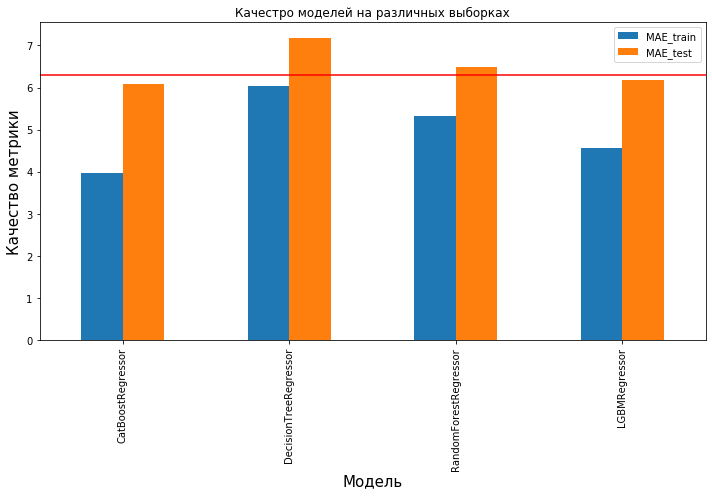

In [42]:
df_score = pd.DataFrame.from_dict(data=test_score, columns=['MAE_train', 'MAE_test', 'time'], orient='index')
display(df_score)

plt.figure(figsize=(10, 7))
plt.subplot(111)
df_score.plot(kind='bar', ax=plt.gca()).hlines(6.3, -1, 5,
                                              color = 'r')
plt.xlabel('Модель', fontsize=15)
plt.ylabel('Качество метрики', fontsize=15)
plt.title('Качестро моделей на различных выборках')

plt.tight_layout()

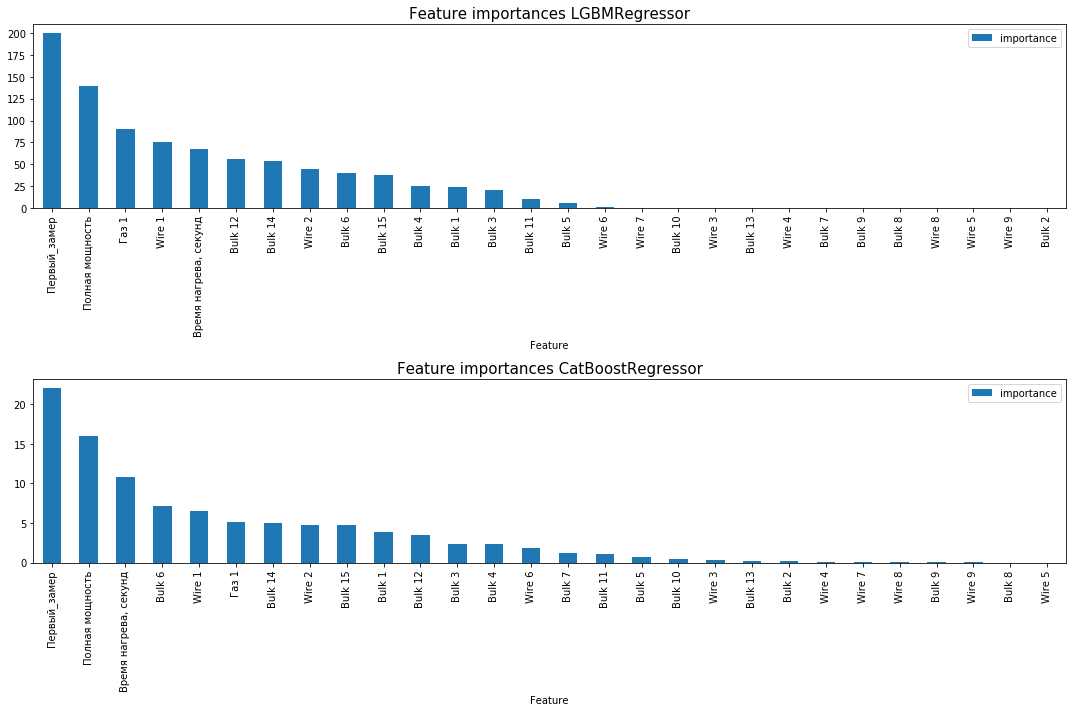

In [43]:
features = df_train.drop(['Последний_замер'], axis=1)
importanc_lgb = (pd.DataFrame({'feature': features.columns, 'importance': model_lgb.feature_importances_})
             .sort_values(by='importance', ascending=False)
            .reset_index()
            )

importanc_cb = (pd.DataFrame({'feature': features.columns, 'importance': modelCatBoost.feature_importances_})
             .sort_values(by='importance', ascending=False)
            .reset_index()
               )

                
plt.figure(figsize=(15, 10))

plt.subplot(211)           
importanc_lgb.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), sharex=False)
plt.xlabel('Feature')
plt.title('Feature importances LGBMRegressor', fontsize=15)

plt.subplot(212)    
importanc_cb.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), sharex=False)
plt.xlabel('Feature')
plt.title('Feature importances CatBoostRegressor', fontsize=15)

plt.tight_layout()

## 5. Выводы.

Для решения поставленной задачи я использовал 4 молели:
-  CatBoostRegressor,
- DecisionTreeRegressor
- RandomForestRegressor
- LGBMRegressor.

Хоршие результаты показали 2 модели:
- CatBoostRegressor MAE_test=6.09
- LGBMRegressor MAE_test=6.18

Разница в результатах не больная но стоит отметить, что LGBMRegressor рабоатет значительно быстрее, но точность лучше у CatBoostRegressor.
Для данной задачи высокая скорость прогноза не требуется, поэтому лучше использовать CatBoostRegressor

Также стоит обратить внимание, что для данных моделей важность признаков расположена в разном порядке, но Первый замер и Полная мощность имеюм вожное место в обоих моделях.